<a href="https://colab.research.google.com/github/Dohun-Im/Biz-Lab/blob/main/%EC%A3%BC%EC%84%9D%EC%9D%98%20%ED%99%98%EC%9C%A8%EB%B3%80%EB%8F%99%EC%9C%84%ED%97%98%20%ED%81%AC%EB%A1%A4%EB%A7%81%20%EB%B0%8F%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendartreader

In [ ]:
pip install --upgrade opendartreader

In [ ]:
import pandas as pd
import re
import glob
import requests
import xml.etree.ElementTree as ET
import zipfile
import io
import csv
import os, re, codecs
import json
import numpy as np
import datetime
try:
    from io import BytesIO
    from pandas import json_normalize
    from pandas import DataFrame as df
except ImportError:
    from pandas.io.json import json_normalize
import OpenDartReader
from bs4 import BeautifulSoup
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
api_key = '7db383648d5f4f8c07f2c066a1ab12ff84b97e8b'
dart = OpenDartReader(api_key)

In [ ]:
os.chdir(r'/content/drive/MyDrive/주석txt/')
st = pd.read_excel(r'/content/drive/MyDrive/주석txt/회사정보 list.xlsx')
st = st['symbol'].str.replace(r'[^\d]','')
st
# st1 = st[0:600]
# st2 = st[600:1200]
# st3 = st[1200:]


In [ ]:
#연결재무제표 주석 크롤링
for m in st1:
  try:
    report = dart.list(m, start = '2016',end= '2021.4.29', kind='A',final=True) 
    report_사업보고서 = report[report['report_nm'].str.contains('사업')]
    report2 = report_사업보고서[['corp_name','stock_code','rcept_no','rcept_dt','report_nm']]
    n = report2['rcept_no']
   
    
    dt = report2['report_nm']
    dt = ''.join(dt) 
    korean = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')
    dt = re.sub(korean,'',dt)
    dt = re.sub(r'[^a-zA-Z0-9]', '', dt)
    dt = re.sub('12','',dt)
    def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
    dt = list_chunk(dt, 4)
    for j,d in zip(n,dt):
      sub_report = dart.sub_docs(j)
      try:
        url = sub_report.loc[sub_report['title'].str.contains('주석'), 'url'].values[0]
        soup = BeautifulSoup(requests.get(url).text)
        soup = soup.text  
        with open('/content/drive/MyDrive/주석txt/연결/'+m+d+j+'.txt', 'w', encoding= 'utf-8') as file:
          file.write(soup)
      except IndexError:
        continue
      
    continue
  except IndexError:
    continue
  except: {"status":"013","message":"조회된 데이타가 없습니다."}
  continue
    

In [ ]:
#연결재무제표 주석 카운트
os.chdir(r'/content/drive/MyDrive/주석txt/연결')
name = os.listdir(r'/content/drive/MyDrive/주석txt/연결')
# del name[0]
# name
len(name)
#연결 주석 개수 -11206

In [ ]:
os.chdir(r'/content/drive/MyDrive/주석txt/연결')
name = os.listdir(r'/content/drive/MyDrive/주석txt/연결')
# del name[0]
name_1 = name[0:4000]
name_2 = name[4000:8000]
name_3 = name[8000:]
name_1

In [ ]:
#테이블 크롤링1 - '영향은 다음과 같습니다' 로 찾기
os.chdir(r'/content/drive/MyDrive/주석txt/연결')
for o in name_3:
    rcept_no = o[10:24]
    fyr = o[6:10]
    symbol = 'A'+ o[0:6]
    file_name = o[0:24]
    
    f = open(r'/content/drive/MyDrive/주석txt/연결/'+ o, 'r',  encoding = 'utf-8') 
    web = f.read()
    web = re.sub(r'\xa0', '',web)
    
    x = '시장위험'
    if web.find(x) != -1:
      n = web.find(x)
      nn = len(web)
      web_temp = web[n:nn]
      xx = '환위험'
      if web_temp.find(xx) != -1:
        z = web_temp.find(xx)
        web_temp = web_temp[z:nn]                   
          
        try:
          nnn = web_temp.find('영향은 다음과 같습니다')
          web_temp = web_temp[nnn-45:nn]  
          vola = re.findall('\d{1,2}%', web_temp)[0]
            
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('산정하였습니다')  
          web_temp = web_temp[nnn:nn]
         
          web_temp = re.sub(r'\xa0', '',web_temp) 
          web_temp = re.sub(' ', '', web_temp)
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
           
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
          
          for measure in web_temp2:
              k = '(단위'
              if k in  web_temp2[0]: 
                pass
              elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                web_temp2.insert(0,'(단위:원)')
                  
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
          web_temp3 = web_temp2[:15]
          s = 'USD'                      
          for word in web_temp3:
            try:
              if s in word:
                web_search = web_temp3.index(s) 
              elif s not in word:
                web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')                     
              else:
                web_search = 0
            except ValueError:
                web_search = 0
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          try:
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
          except NameError:
            pass 
          try:
            if l == 5:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
        
            elif l == 3:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
               
            elif l == 9:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
               
            else:
              pass

            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]

            df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
          except:
            continue
       
        except IndexError:
          continue
        
      elif web_temp.find(xx) == -1:
        z = web_temp.find('환율변동위험')
        web_temp = web_temp[z:nn]                         
        try:
          nnn = web_temp.find('영향은 다음과 같습니다')
          web_temp = web_temp[nnn-45:nn]   
          vola = re.findall('\d{1,2}%', web_temp)[0]
            
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          web_temp = web_temp[nnn:nn]  
          web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
          
          for measure in web_temp2:
              k = '(단위'
              if k in  web_temp2[0]: 
                pass
              elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                web_temp2.insert(0,'(단위:원)')
                  
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
          web_temp3 = web_temp2[:15]
          s = 'USD'                      
          for word in web_temp3:
            try:
              if s in word:
                web_search = web_temp3.index(s) 
              elif s not in word:
                web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')                      
              else:
                continue
            except ValueError:
                continue
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          try:  
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
          except NameError:
            pass  
          try:
            if l == 5:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
               
            elif l == 3:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                
            elif l == 9:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                
            else:
              pass

            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]

            df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
          except:
            continue
       
        except IndexError:
          continue
        
      
    elif web.find(x) == -1:
      continue    
    
   




In [ ]:
#테이블크롤링2: '환율 n% 변동시~' 기준으로 찾기
os.chdir(r'/content/drive/MyDrive/주석txt/연결')
for o in name_3:
    rcept_no = o[10:24]
    fyr = o[6:10]
    symbol = 'A'+ o[0:6]
    file_name = o[0:24]
    
    f = open(r'/content/drive/MyDrive/주석txt/연결/'+ o, 'r',  encoding = 'utf-8') 
    web = f.read()
    web = re.sub(r'\xa0', '',web)
    
    x = '시장위험'
    if web.find(x) != -1:
      n = web.find(x)
      nn = len(web)
      web_temp = web[n:nn]
      xx = '환위험'
      if web_temp.find(xx) != -1:
        z = web_temp.find(xx)
        web_temp = web_temp[z:nn]                         
        try:
          st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
          zz = web_temp.find(st_word) 
          web_temp_1 = web_temp[:zz]
          web_temp = web_temp[zz:nn]                    
          vola = re.findall('\d{1,2}%', web_temp)[0] 
          
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('산정하였습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('결과입니다')  
          web_temp = web_temp[nnn:nn]
            
          web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
          
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
          
          for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
              k = '(단위'
              if k in  web_temp2[0]: 
                pass
              elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                web_temp2.insert(0,'(단위:원)')
                  
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
            
          web_temp3 = web_temp2[:15]
          s = 'USD'                      
          for word in web_temp3:
            try:
              if s in word:
                web_search = web_temp3.index(s) 
              elif s not in word:
                web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')
                                   
              else:
                continue
            except ValueError:
                continue
            except NameError:
                continue
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          try:  
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
          except NameError:
            pass  
          try:
            if l == 5:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                
            elif l == 3:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
               
            elif l == 9:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
               
            else:
              pass

            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]

            df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
          except:
            continue
       
        except IndexError:
          continue
        
      elif web_temp.find(xx) == -1:
        z = web_temp.find('환율변동위험')
        web_temp = web_temp[z:nn]                         
        try:
          st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
          zz = web_temp.find(st_word) 
          web_temp_1 = web_temp[:zz]
          web_temp = web_temp[zz:nn]
   
          vola = re.findall('\d{1,2}%', web_temp)[0]
            
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('산정하였습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('결과입니다')
          web_temp = web_temp[nnn:nn]  
          web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
         
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
          
          for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
              k = '(단위'
              if k in  web_temp2[0]: 
                pass
              elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                web_temp2.insert(0,'(단위:원)')
                  
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
           
          web_temp3 = web_temp2[:15]
          s = 'USD'                      
          for word in web_temp3:
            try:
              if s in word:
                web_search = web_temp3.index(s) 
              elif s not in word:
                web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')
                                   
              else:
                continue
            except ValueError:
                continue
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          if l > 0:
            list_chunked = list_chunk(web_temp2, l)
            df = pd.DataFrame(list_chunked)
            
          try:
            if l == 5:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
              
            elif l == 3:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                
            elif l == 9:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
               
            else:
              pass

            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]

            df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
          except:
            continue
       
        except IndexError:
          continue
        
      
    elif web.find(x) == -1:
      continue    
    

In [ ]:
#테이블크롤링3: '민감도~'기준으로 찾기
os.chdir(r'/content/drive/MyDrive/주석txt/연결')
for o in name_3:
    rcept_no = o[10:24]
    fyr = o[6:10]
    symbol = 'A'+ o[0:6]
    file_name = o[0:24]
    
    f = open(r'/content/drive/MyDrive/주석txt/연결/'+ o, 'r',  encoding = 'utf-8') 
    web = f.read()
    web = re.sub(r'\xa0', '',web)
    
    x = '시장위험'
    if web.find(x) != -1:
      n = web.find(x)
      nn = len(web)
      web_temp = web[n:nn]
      xx = '환위험'
      if web_temp.find(xx) != -1:
        z = web_temp.find(xx)
        web_temp = web_temp[z:nn]                   
        gex = re.compile('(.*){}'.format(re.escape('.'))) #여기서부터 리스트로 바뀐결과 출력됨.
        web_temp_dummy = gex.findall(web_temp)
        web_temp_dummy = list(filter(None, web_temp))
         
        if re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp) not in web_temp_dummy:
          try:
            if re.findall('환율.+민감도' , web_temp)[0] in web_temp_dummy:
              st_word = re.findall('환율.+민감도' , web_temp)[0]
            elif re.findall('환율.+민감도' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('민감도분석.+같습니다' , web_temp)[0]
            elif re.findall('민감도분석.+같습니다' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('영향은다음과같습니다',web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
    
            vola = re.findall('\d{1,2}%', web_temp)[0]
  
            xxx='같습니다'
            
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')  
            web_temp = web_temp[nnn:nn]
             
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp2 = web_temp 
             
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              continue
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
              
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')
                else:
                  continue   
              except ValueError:
                  continue
            if web_search > 0:        
              try: 
                del web_temp2[0:web_search] #단위:~,, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                if web_search == 8:
                  l = 5
                  i = 40
                elif web_search == 4:
                  l = 3  
                  i= 24
                elif web_search == 5:
                  l = 3
                  i = 24
                elif web_search == 16:
                  l = 9
                  i = 72  
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
              except TypeError: 
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
            list_chunked = list_chunk(web_temp2, l)
            df = pd.DataFrame(list_chunked)
            try:
              if l == 5:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                    
              elif l == 3:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                
              elif l == 9:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                    
              else:
                pass
              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산|외화금융부채')
              df =  df[only_x]  
              df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')

            except ValueError:
              continue   

          except IndexError:
            continue
        else:
          continue



           
      elif web_temp.find(xx) == -1:
        z = web_temp.find('환율변동위험')
        web_temp = web_temp[z:nn]                                
        gex = re.compile('(.*){}'.format(re.escape('.'))) #여기서부터 리스트로 바뀐결과 출력됨.
        web_temp_dummy = gex.findall(web_temp)
        web_temp_dummy = list(filter(None, web_temp))
          
        if re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp) not in web_temp_dummy:
          try:
            if re.findall('환율.+민감도' , web_temp)[0] in web_temp_dummy:
              st_word = re.findall('환율.+민감도' , web_temp)[0]
            elif re.findall('환율.+민감도' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('민감도분석.+같습니다' , web_temp)[0]
            elif re.findall('민감도분석.+같습니다' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('영향은다음과같습니다',web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
     
            vola = re.findall('\d{1,2}%', web_temp)[0]
  
            xxx='같습니다'
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')
            web_temp = web_temp[nnn:nn]
           
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp2 = web_temp 
             
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              pass
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
          
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')                      
                else:
                  continue
              except ValueError:
                  continue
            if web_search > 0:   
              try:    
                del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                if web_search == 8:
                  l = 5
                  i = 40
                elif web_search == 4:
                  l = 3  
                  i= 24
                elif web_search == 5:
                  l = 3
                  i = 24
                elif web_search == 16:
                  l = 9
                  i = 72                             
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
              except TypeError: 
                pass
              except NameError:
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
              
            try:
              if l == 5:
                  df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                  df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                  df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                  df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                  df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                  df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                  df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                 
              elif l == 3:
                  df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                  df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                  df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                  df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                  df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                  df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                  
              elif l == 9:
                  df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                  df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                  df.insert(0, 'consol',['1','1','1','1','1','1','1','1'],True)
                  df.insert(0, 'fyr',[fyr,fyr,fyr,fyr,fyr,fyr,fyr,fyr],True),
                  df.insert(0, 'symbol',[symbol,symbol,symbol,symbol,symbol,symbol,symbol,symbol],True)
                  df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no,rcept_no],True)
                  df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                  df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                 
              else:
                pass

              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
              df =  df[only_x]

              df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
            except:
              continue
       
          except IndexError:
            continue
      
    elif web.find(x) == -1:
      continue 

In [ ]:
#테이블크롤링 1,2,3 결과들 중 빈 데이터프레임 삭제
os.chdir(r'/content/drive/MyDrive/주석txt/연결_table')
name_ex = os.listdir(r'/content/drive/MyDrive/주석txt/연결_table')
for ss in name_ex: 
  ex = pd.read_excel(ss)
  if ex.empty:
    os.remove(ss)

In [ ]:
#테이블크롤링 1,2,3이 찾지 못한 테이블 크롤링4: '행과 열의 형식이 다를때'
os.chdir(r'/content/drive/MyDrive/주석txt')
name1 = os.listdir(r'/content/drive/MyDrive/주석txt/연결')
def list(lst1):
  new = []
  for fn in lst1:
    dlfma = fn[0:24]
    new.append(dlfma)
  return new
a = list(name1)  
name2 = os.listdir(r'/content/drive/MyDrive/주석txt/연결_table')
b = list(name2)
a_sub_b = [x for x in a if x not in b]
a_sub_b

for o in a_sub_b:
    rcept_no = o[10:24]
    fyr = o[6:10]
    symbol = 'A'+ o[0:6]
    file_name = o[0:24]
    try:
      f = open(r'/content/drive/MyDrive/주석txt/연결/'+ o+'.txt', 'r',  encoding = 'utf-8') 
      web = f.read()
      web = re.sub(r'\xa0', '',web)
      
      x = '시장위험'
      if web.find(x) != -1:
        n = web.find(x)
        nn = len(web)
        web_temp = web[n:nn]
        xx = '환위험'
        if web_temp.find(xx) != -1:
          z = web_temp.find(xx)
          web_temp = web_temp[z:nn]                   
        
          try:
            st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]

            vola = re.findall('\d{1,2}%', web_temp)[0]
              
            xxx='같습니다'
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('결과입니다')  
            web_temp = web_temp[nnn:nn]
            
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원환율','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp = re.sub(r'미국달러','USD',web_temp)
            web_temp = re.sub(r'유로','EUR',web_temp)
            web_temp = re.sub(r'중국위안화','CNY',web_temp)
            web_temp = re.sub(r'일본엔화','JPY',web_temp)
            
            web_temp2 = web_temp 
            
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              pass
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
            
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익')                    
                else:
                  continue
              except ValueError:
                  continue
            if web_search > 0:   
              try:    
                del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                l = 3
                i = 30        
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
                del web_temp2[1]
                del web_temp2[2:6]
                del web_temp2[3:6]
                del web_temp2[4]
                del web_temp2[5:9]
                del web_temp2[6:9]
                del web_temp2[7]
                del web_temp2[8:12]
                del web_temp2[9:12]
              except TypeError: 
                pass
              except NameError:
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
          
            list_chunked = list_chunk(web_temp2, l)
            df = pd.DataFrame(list_chunked)     
                  
            try:                   
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위],True)
              df.insert(0, 'consol',['1','1','1'],True)
              df.insert(0, 'fyr',[fyr,fyr,fyr],True),
              df.insert(0, 'symbol',[symbol,symbol,symbol],True)
              df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no],True)
                      
              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
              df =  df[only_x]
              # print(df)
              df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
            except:
              continue
        
          except IndexError:
            continue
          
        elif web_temp.find(xx) == -1:
          z = web_temp.find('환율변동위험')
          web_temp = web_temp[z:nn]                   
              
          try:
            st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
        
            vola = re.findall('\d{1,2}%', web_temp)[0]
              
            xxx='같습니다'
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('결과입니다')
            web_temp = web_temp[nnn:nn]
            
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원환율','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp = re.sub(r'미국달러','USD',web_temp)
            web_temp = re.sub(r'유로','EUR',web_temp)
            web_temp = re.sub(r'중국위안화','CNY',web_temp)
            web_temp = re.sub(r'일본엔화','JPY',web_temp)
            web_temp2 = web_temp
              
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              pass
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
            
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익')
                                    
                else:
                  continue
              except ValueError:
                  continue
            if web_search > 0:   
              try:
                del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                l = 3
                i = 30        
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
                del web_temp2[1]
                del web_temp2[2:6]
                del web_temp2[3:6]
                del web_temp2[4]
                del web_temp2[5:9]
                del web_temp2[6:9]
                del web_temp2[7]
                del web_temp2[8:12]
                del web_temp2[9:12]
              except TypeError: 
                pass
              except NameError:
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)  
            try:                   
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위],True)
              df.insert(0, 'consol',['1','1','1'],True)
              df.insert(0, 'fyr',[fyr,fyr,fyr],True),
              df.insert(0, 'symbol',[symbol,symbol,symbol],True)
              df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no],True)
                  # df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no],True)
            

              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
              df =  df[only_x]

              df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
            except:
              continue
        
          except IndexError:
            continue
    except:
      continue
    

In [ ]:
#테이블크롤링 5: VAR형식의 공시를 한 기업들의 정보 크롤링
os.chdir(r'/content/drive/MyDrive/주석txt')
name3 = os.listdir(r'/content/drive/MyDrive/주석txt/연결')
def list(lst1):
  new = []
  for fn in lst1:
    dlfma = fn[0:24]
    new.append(dlfma)
  return new
a = list(name3)  
name4 = os.listdir(r'/content/drive/MyDrive/주석txt/연결_table')
b = list(name4)
a_sub_b = [x for x in a if x not in b]
a_sub_b

for o in a_sub_b:
    rcept_no = o[10:24]
    fyr = o[6:10]
    symbol = 'A'+ o[0:6]
    file_name = o[0:24]
    try:
      f = open(r'/content/drive/MyDrive/주석txt/연결/'+ o+'.txt', 'r',  encoding = 'utf-8') 
      web = f.read()
      web = re.sub(r'\xa0', '',web)
      
      x = '시장위험'
      if web.find(x) != -1:
        n = web.find(x)
        nn = len(web)
        web_temp = web[n:nn]
        xx = '환위험'
        if web_temp.find(xx) != -1:
          z = web_temp.find(xx)
          web_temp = web_temp[z:nn] 
          # web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          # web_temp = re.sub(' ', '', web_temp) #빈 공간 제거                  
              
          try:  
            st_word = re.findall('\d*\.?\d*%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
                        
            vola = re.findall('\d{1,2}\.?\d*?%', web_temp)[0]
            won = re.findall('원|천원|백만원',web_temp)[0]
            단위 = '(단위:'+ won+')'
            gubun = re.findall('세전이익|세전순이익|법인세차감전순이익|법인세비용차감전순이익',web_temp)[0]

            web_temp = re.sub(vola, '', web_temp)
            web_temp = re.sub('[-=#/?:$})]', '', web_temp)
            effect = re.findall('\d{1,3}(?:,\d{3})*(?:\.\d+)?(?!\d)', web_temp)[0]
            varlist = [gubun,effect,'('+effect+')']
            def list_chunk(lst, n):
                return [lst[i:i+n] for i in range(0, len(lst), n)]
              
            list_chunked = list_chunk(varlist, 3)
            df = pd.DataFrame(list_chunked)
          
            df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
            df.insert(0, '단위',[단위],True)
            df.insert(0, 'consol',['1'],True)
            df.insert(0, 'fyr',[fyr],True),
            df.insert(0, 'symbol',[symbol],True)
            df.insert(0, 'rcept_num',[rcept_no],True)

            df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
          except:
            pass  

      if web.find(x) == -1:
          n = web.find('환위험')
          nn = len(web)
          web_temp = web[n:nn]
        
          z = web_temp.find('환위험')
          web_temp = web_temp[z:nn]                 
                
          try:
            s_word = re.findall('\d*\.?\d*%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
                          
            vola = re.findall('\d{1,2}\.?\d*?%', web_temp)[0]
            won = re.findall('원|천원|백만원',web_temp)[0]
            단위 = '(단위:'+ won+')'
            gubun = re.findall('세전이익|세전순이익|법인세차감전순이익|법인세비용차감전순이익',web_temp)[0]

            web_temp = re.sub(vola, '', web_temp)
            web_temp = re.sub('[-=#/?:$})]', '', web_temp)
            effect = re.findall('\d{1,3}(?:,\d{3})*(?:\.\d+)?(?!\d)', web_temp)[0]
            varlist = [gubun,effect,'('+effect+')']
            def list_chunk(lst, n):
                return [lst[i:i+n] for i in range(0, len(lst), n)]
              
            list_chunked = list_chunk(varlist, 3)
            df = pd.DataFrame(list_chunked)
        
            df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
            df.insert(0, '단위',[단위],True)
            df.insert(0, 'consol',['1'],True)
            df.insert(0, 'fyr',[fyr],True),
            df.insert(0, 'symbol',[symbol],True)
            df.insert(0, 'rcept_num',[rcept_no],True)
          

            df.to_excel('/content/drive/My Drive//주석txt/연결_table/'+file_name+'.xlsx')
          except:
            pass
    except:
      continue
      
       


In [ ]:
#테이블크롤링 1,2,3,4,5 결과들 중 빈 데이터프레임 삭제
os.chdir(r'/content/drive/MyDrive/주석txt/연결_table')
name_ex = os.listdir(r'/content/drive/MyDrive/주석txt/연결_table')
for ss in name_ex: 
  ex = pd.read_excel(ss)
  if ex.empty:
    os.remove(ss)

In [ ]:
#연결재무제표 주석 테이블 카운트
os.chdir(r'/content/drive/MyDrive/주석txt/연결_table')
name = os.listdir(r'/content/drive/MyDrive/주석txt/연결_table')
# del name[0]
name
len(name)
#연결 주석 개수 11206
# 테이블 개수 - 5728

5728

In [ ]:
#개별 재무제표 주석 크롤링
for b in st1:
  try:
    report = dart.list(b, start = '2016',end= '2021.4.29', kind='A',final=True) #start 는 나중에 바꾸자
    report_사업보고서 = report[report['report_nm'].str.contains('사업')]
    report2 = report_사업보고서[['corp_name','stock_code','rcept_no','rcept_dt','report_nm']]
    h = report2['rcept_no']
    dt_i = report2['report_nm']
    dt_i = ''.join(dt_i) 
    korean = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')
    dt_i = re.sub(korean,'',dt_i)
    dt_i = re.sub(r'[^a-zA-Z0-9]', '', dt_i)
    dt_i = re.sub('12','',dt_i)
    def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
    dt_i = list_chunk(dt_i, 4)
    for v,d in zip(h,dt_i):
      sub_report = dart.sub_docs(v)
      try:
        url = sub_report.loc[sub_report['title'].str.contains('주석'), 'url'].values[1]
        soup = BeautifulSoup(requests.get(url).text)
        soup = soup.text
        
        with open('/content/drive/MyDrive/주석txt/개별/'+b+d+v+'.txt', 'w', encoding= 'utf-8') as file:
          file.write(soup)
      except IndexError:
        continue
  except KeyError:
    continue
  except IndexError:
    continue
  except: {"status":"013","message":"조회된 데이타가 없습니다."}
  continue
  

In [ ]:
os.chdir(r'/content/drive/MyDrive/주석txt/개별')
name_i = os.listdir(r'/content/drive/MyDrive/주석txt/개별')
# del name[0]
name_i
# len(name_i) #- 11070개

In [ ]:
os.chdir(r'/content/drive/MyDrive/주석txt/개별')
name_i = os.listdir(r'/content/drive/MyDrive/주석txt/개별')
name_i_1 = name_i[0:4000]
name_i_2 = name_i[4000:8000]
name_i_3 = name_i[8000:]



In [ ]:
os.chdir(r'/content/drive/MyDrive/주석txt/연결')
name_i = os.listdir(r'/content/drive/MyDrive/주석txt/연결')
def list(lst1):
  new = []
  for fn in lst1:
    fyrr = fn[6:10]
    new.append(fyrr)
  return new
a = list(name_i)
c2016 = a.count('2019') 
c2016                   


1927

In [ ]:
#테이블 크롤링1 - '영향은 다음과 같습니다' 로 찾기
# os.chdir(r'/content/drive/MyDrive/주석txt/개별')
for u in name_i_3:
  rcept_no_i = u[10:24]
  fyr_i = u[6:10]
  symbol_i = 'A'+ u[0:6]
  file_name_i = u[0:24]   
  try:
    f = open(r'/content/drive/My Drive/주석txt/개별/'+ u, 'r',  encoding = 'utf-8')     
    web = f.read()
    web = re.sub(r'\xa0', '',web)  
    x = '시장위험'
    if web.find(x) != -1:
      n = web.find(x)
      nn = len(web)
      web_temp = web[n:nn]
      xx = '환위험'
      if web_temp.find(xx) != -1:
        z = web_temp.find(xx)
        web_temp = web_temp[z:nn]                             
        
        try:
          nnn = web_temp.find('영향은 다음과 같습니다')
          web_temp = web_temp[nnn-45:nn]  
          vola = re.findall('\d{1,2}%', web_temp)[0]
              
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('산정하였습니다')  
          web_temp = web_temp[nnn:nn]
          
          web_temp = re.sub(r'\xa0', '',web_temp) 
          web_temp = re.sub(' ', '', web_temp)
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
            
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
            
          for measure in web_temp2:
              k = '(단위'
              if k in  web_temp2[0]: 
                pass
              elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                web_temp2.insert(0,'(단위:원)')
                    
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
          web_temp3 = web_temp2[:15]
                        
            # for word in web_temp3:
          try:
            if 'USD' in web_temp3:
              web_search = web_temp3.index('USD') 
            elif 'USD' not in web_temp3:
              web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')                     
            else:
              web_search = 0
          except ValueError:
              web_search = 0
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          try:
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
          except NameError:
            pass 
          try:
            if l == 5:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
          
            elif l == 3:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                
            elif l == 9:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                
            else:
              pass

            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]
              
            df.to_excel('/content/drive/My Drive/주석txt/개별_table/'+file_name_i+'.xlsx')
          except:
            continue  
        except:
          continue
              
      elif web_temp.find(xx) == -1:
        z = web_temp.find('환율변동위험')
        web_temp = web_temp[z:nn]                         
        try:
          nnn = web_temp.find('영향은 다음과 같습니다')
          web_temp = web_temp[nnn-45:nn]   
          vola = re.findall('\d{1,2}%', web_temp)[0]
              
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          web_temp = web_temp[nnn:nn]  
          web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
            
          for measure in web_temp2:
            k = '(단위'
            if k in  web_temp2[0]: 
              pass
            elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
              web_temp2.insert(0,'(단위:원)')
                    
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
          web_temp3 = web_temp2[:15]
                                
            # for word in web_temp3:
          try:
            if 'USD' in web_temp3:
              web_search = web_temp3.index('USD') 
            elif 'USD' not in web_temp3:
              web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')                      
            else:
              pass
          except ValueError:
            continue
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          try:  
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
          except NameError:
            pass  
          try:
            if l == 5:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                
            elif l == 3:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                  
            elif l == 9:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[cept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                  
            else:
              pass
          
            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]
              
            df.to_excel(r'/content/drive/MyDrive/주석txt/개별_table/'+file_name_i+'.xlsx')
          except:
            continue    
            
        
        except IndexError:
          continue
        
      
    elif web.find(x) == -1:
      continue 
  except:
    continue    


In [ ]:
#테이블크롤링2: '환율 n% 변동시~' 기준으로 찾기
os.chdir(r'/content/drive/MyDrive/주석txt/개별')
name_i_3.remove('docs_cache') 
for u in name_i_3:
  rcept_no_i = u[10:24]
  fyr_i = u[6:10]
  symbol_i = 'A'+ u[0:6]
  file_name_i = u[0:24]
    
  f = open(r'/content/drive/MyDrive/주석txt/개별/'+ u, 'r',  encoding = 'utf-8') 
  web = f.read()
  web = re.sub(r'\xa0', '',web)
    
  x = '시장위험'
  if web.find(x) != -1:
      n = web.find(x)
      nn = len(web)
      web_temp = web[n:nn]
      xx = '환위험'
      if web_temp.find(xx) != -1:
        z = web_temp.find(xx)
        web_temp = web_temp[z:nn]                         
        try:
          st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
          zz = web_temp.find(st_word) 
          web_temp_1 = web_temp[:zz]
          web_temp = web_temp[zz:nn]                    
          vola = re.findall('\d{1,2}%', web_temp)[0] 
          
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('산정하였습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('결과입니다')  
          web_temp = web_temp[nnn:nn]
            
          web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
          
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
          
          for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
              k = '(단위'
              if k in  web_temp2[0]: 
                pass
              elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                web_temp2.insert(0,'(단위:원)')
                  
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
            
          web_temp3 = web_temp2[:15]
          s = 'USD'                      
          for word in web_temp3:
            try:
              if s in word:
                web_search = web_temp3.index(s) 
              elif s not in word:
                web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')
                                   
              else:
                continue
            except ValueError:
                continue
            except NameError:
                continue
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          try:  
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
          except NameError:
            pass  
          try:
            if l == 5:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
          
            elif l == 3:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                
            elif l == 9:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
               
            else:
              pass

            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]

            df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')
          except:
            continue
       
        except IndexError:
          continue
        
      elif web_temp.find(xx) == -1:
        z = web_temp.find('환율변동위험')
        web_temp = web_temp[z:nn]                         
        try:
          st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
          zz = web_temp.find(st_word) 
          web_temp_1 = web_temp[:zz]
          web_temp = web_temp[zz:nn]
   
          vola = re.findall('\d{1,2}%', web_temp)[0]
            
          xxx='같습니다'
          if web_temp.find(xxx) != -1:
            nnn = web_temp.find('같습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('나타냅니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('산정하였습니다')
          elif web_temp.find(xxx) == -1:
            nnn = web_temp.find('결과입니다')
          web_temp = web_temp[nnn:nn]  
          web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
          web_temp = re.sub('효과','',web_temp)
          web_temp = re.sub('증가(감소)','',web_temp)
          web_temp = re.sub(r'/원','',web_temp)
          web_temp = re.sub(r'원/','',web_temp)
          web_temp2 = web_temp 
         
          regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
          web_temp2 = regex.findall(web_temp2)
          web_temp2 = list(filter(None, web_temp2))
          if len(web_temp2) > 0:
            del web_temp2[0] #'같습니다' 삭제
          elif len(web_temp2) == 0:
            pass
          
          for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
              k = '(단위'
              if k in  web_temp2[0]: 
                pass
              elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                web_temp2.insert(0,'(단위:원)')
                  
          단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
           
          web_temp3 = web_temp2[:15]
          s = 'USD'                      
          for word in web_temp3:
            try:
              if s in word:
                web_search = web_temp3.index(s) 
              elif s not in word:
                web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')
                                   
              else:
                continue
            except ValueError:
                continue
          if web_search > 0:   
            try:    
              del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
              if web_search == 8:
                l = 5
                i = 40
              elif web_search == 4:
                l = 3  
                i= 24
              elif web_search == 5:
                l = 3
                i = 24
              elif web_search == 16:
                l = 9
                i = 72                             
              web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
            except TypeError: 
              pass
            except NameError:
              pass
          def list_chunk(lst, n):
            return [lst[i:i+n] for i in range(0, len(lst), n)]
          if l > 0:
            list_chunked = list_chunk(web_temp2, l)
            df = pd.DataFrame(list_chunked)
            
          try:
            if l == 5:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
          
            elif l == 3:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                
            elif l == 9:
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
              df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
              df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
               
            else:
              pass

            only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
            df =  df[only_x]

            df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')
          except:
            continue
       
        except IndexError:
          continue
        
      
  elif web.find(x) == -1:
      continue    
    

In [ ]:
#테이블크롤링3: '민감도~'기준으로 찾기
os.chdir(r'/content/drive/MyDrive/주석txt/개별')
name_i.remove('docs_cache') 
for u in name_i:
    rcept_no_i = u[10:24]
    fyr_i = u[6:10]
    symbol_i = 'A'+ u[0:6]
    file_name_i = u[0:24]
    
    f = open(r'/content/drive/MyDrive/주석txt/개별/'+ u, 'r',  encoding = 'utf-8') 
    web = f.read()
    web = re.sub(r'\xa0', '',web)
    
    x = '시장위험'
    if web.find(x) != -1:
      n = web.find(x)
      nn = len(web)
      web_temp = web[n:nn]
      xx = '환위험'
      if web_temp.find(xx) != -1:
        z = web_temp.find(xx)
        web_temp = web_temp[z:nn]                   
        gex = re.compile('(.*){}'.format(re.escape('.'))) #여기서부터 리스트로 바뀐결과 출력됨.
        web_temp_dummy = gex.findall(web_temp)
        web_temp_dummy = list(filter(None, web_temp))
         
        if re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp) not in web_temp_dummy:
          try:
            if re.findall('환율.+민감도' , web_temp)[0] in web_temp_dummy:
              st_word = re.findall('환율.+민감도' , web_temp)[0]
            elif re.findall('환율.+민감도' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('민감도분석.+같습니다' , web_temp)[0]
            elif re.findall('민감도분석.+같습니다' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('영향은다음과같습니다',web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
    
            vola = re.findall('\d{1,2}%', web_temp)[0]
  
            xxx='같습니다'
            
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')  
            web_temp = web_temp[nnn:nn]
             
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp2 = web_temp 
             
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              continue
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
              
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')
                else:
                  continue   
              except ValueError:
                  continue
            if web_search > 0:        
              try: 
                del web_temp2[0:web_search] #단위:~,, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                if web_search == 8:
                  l = 5
                  i = 40
                elif web_search == 4:
                  l = 3  
                  i= 24
                elif web_search == 5:
                  l = 3
                  i = 24
                elif web_search == 16:
                  l = 9
                  i = 72  
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
              except TypeError: 
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
            list_chunked = list_chunk(web_temp2, l)
            df = pd.DataFrame(list_chunked)
            try:
              if l == 5:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
                df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
                df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
                df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
            
              elif l == 3:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
                df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
                df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
                df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                  
              elif l == 9:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
                df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
                df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
                df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                      
              else:
                pass
              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산|외화금융부채')
              df =  df[only_x]  
              df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')

            except:
              continue  

          except IndexError:
            continue
        else:
          continue



           
      elif web_temp.find(xx) == -1:
        z = web_temp.find('환율변동위험')
        web_temp = web_temp[z:nn]                                
        gex = re.compile('(.*){}'.format(re.escape('.'))) #여기서부터 리스트로 바뀐결과 출력됨.
        web_temp_dummy = gex.findall(web_temp)
        web_temp_dummy = list(filter(None, web_temp))
          
        if re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp) not in web_temp_dummy:
          try:
            if re.findall('환율.+민감도' , web_temp)[0] in web_temp_dummy:
              st_word = re.findall('환율.+민감도' , web_temp)[0]
            elif re.findall('환율.+민감도' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('민감도분석.+같습니다' , web_temp)[0]
            elif re.findall('민감도분석.+같습니다' , web_temp)[0] not in web_temp_dummy:
              st_word = re.findall('영향은다음과같습니다',web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
     
            vola = re.findall('\d{1,2}%', web_temp)[0]
  
            xxx='같습니다'
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')
            web_temp = web_temp[nnn:nn]
           
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp2 = web_temp 
             
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              pass
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
          
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익|외화금융자산')                      
                else:
                  continue
              except ValueError:
                  continue
            if web_search > 0:   
              try:    
                del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                if web_search == 8:
                  l = 5
                  i = 40
                elif web_search == 4:
                  l = 3  
                  i= 24
                elif web_search == 5:
                  l = 3
                  i = 24
                elif web_search == 16:
                  l = 9
                  i = 72                             
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
              except TypeError: 
                pass
              except NameError:
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)
              
            try:
              if l == 5:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
                df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
                df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
                df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
            
              elif l == 3:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
                df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
                df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
                df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                  
              elif l == 9:
                df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시','자본 당기말 환율 '+ vola + ' 하락시','전기말 환율 '+ vola + ' 상승시',' 자본 전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시', '자본 전기말 환율 '+ vola + ' 하락시']
                df.insert(0, '단위',[단위,단위,단위,단위,단위,단위,단위,단위],True)
                df.insert(0, 'consol',['0','0','0','0','0','0','0','0'],True)
                df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i,fyr_i],True),
                df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i,symbol_i],True)
                df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i,rcept_no_i],True)
                df = df.drop(['자본 당기말 환율 '+ vola + ' 상승시','자본 당기말 환율 '+ vola + ' 하락시', ' 자본 전기말 환율 '+ vola + ' 상승시','자본 전기말 환율 '+ vola + ' 하락시'], axis=1)
                df = df.drop(['전기말 환율 '+ vola + ' 상승시','전기말 환율 '+ vola + ' 하락시'], axis=1)
                 
              else:
                pass

              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
              df =  df[only_x]

              df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')
            except:
              continue
       
          except IndexError:
            continue
      
    elif web.find(x) == -1:
      continue 

In [ ]:
#테이블크롤링 1,2,3 결과들 중 빈 데이터프레임 삭제
os.chdir(r'/content/drive/MyDrive/주석txt/개별_table')
name_ex_i = os.listdir(r'/content/drive/MyDrive/주석txt/개별_table')
for sss in name_ex_i: 
  ex = pd.read_excel(sss)
  if ex.empty:
    os.remove(sss)

In [ ]:
#테이블크롤링 1,2,3이 찾지 못한 테이블 크롤링4: '행과 열의 형식이 다를때'
os.chdir(r'/content/drive/MyDrive/주석txt')
name3 = os.listdir(r'/content/drive/MyDrive/주석txt/개별')
def list(lst1):
  new = []
  for fn in lst1:
    dlfma = fn[0:24]
    new.append(dlfma)
  return new
c = list(name3)  
name4 = os.listdir(r'/content/drive/MyDrive/주석txt/개별_table')
d = list(name4)
c_sub_d = [x for x in c if x not in d]
c_sub_d

for u in c_sub_d:
    rcept_no_i = u[10:24]
    fyr_i = u[6:10]
    symbol_i = 'A'+ u[0:6]
    file_name_i = u[0:24]
    try:
      f = open(r'/content/drive/MyDrive/주석txt/개별/'+ u+'.txt', 'r',  encoding = 'utf-8') 
      web = f.read()
      web = re.sub(r'\xa0', '',web)
      
      x = '시장위험'
      if web.find(x) != -1:
        n = web.find(x)
        nn = len(web)
        web_temp = web[n:nn]
        xx = '환위험'
        if web_temp.find(xx) != -1:
          z = web_temp.find(xx)
          web_temp = web_temp[z:nn]                   
        
          try:
            st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]

            vola = re.findall('\d{1,2}%', web_temp)[0]
              
            xxx='같습니다'
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('결과입니다')  
            web_temp = web_temp[nnn:nn]
            
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원환율','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp = re.sub(r'미국달러','USD',web_temp)
            web_temp = re.sub(r'유로','EUR',web_temp)
            web_temp = re.sub(r'중국위안화','CNY',web_temp)
            web_temp = re.sub(r'일본엔화','JPY',web_temp)
            
            web_temp2 = web_temp 
            
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              pass
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
            
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익')                    
                else:
                  continue
              except ValueError:
                  continue
            if web_search > 0:   
              try:    
                del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                l = 3
                i = 30        
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
                del web_temp2[1]
                del web_temp2[2:6]
                del web_temp2[3:6]
                del web_temp2[4]
                del web_temp2[5:9]
                del web_temp2[6:9]
                del web_temp2[7]
                del web_temp2[8:12]
                del web_temp2[9:12]
              except TypeError: 
                pass
              except NameError:
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
          
            list_chunked = list_chunk(web_temp2, l)
            df = pd.DataFrame(list_chunked)     
                  
            try:                   
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i],True)
                      
              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
              df =  df[only_x]
              # print(df)
              df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')
            except:
              continue
        
          except IndexError:
            continue
          
        elif web_temp.find(xx) == -1:
          z = web_temp.find('환율변동위험')
          web_temp = web_temp[z:nn]                   
              
          try:
            st_word = re.findall('환율\w.\d{1,2}%|환율.\d{1,2}%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
        
            vola = re.findall('\d{1,2}%', web_temp)[0]
              
            xxx='같습니다'
            if web_temp.find(xxx) != -1:
              nnn = web_temp.find('같습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('나타냅니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('산정하였습니다')
            elif web_temp.find(xxx) == -1:
              nnn = web_temp.find('결과입니다')
            web_temp = web_temp[nnn:nn]
            
            web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
            web_temp = re.sub(' ', '', web_temp) #빈 공간 제거
            web_temp = re.sub('효과','',web_temp)
            web_temp = re.sub('증가(감소)','',web_temp)
            web_temp = re.sub(r'/원환율','',web_temp)
            web_temp = re.sub(r'/원','',web_temp)
            web_temp = re.sub(r'원/','',web_temp)
            web_temp = re.sub(r'미국달러','USD',web_temp)
            web_temp = re.sub(r'유로','EUR',web_temp)
            web_temp = re.sub(r'중국위안화','CNY',web_temp)
            web_temp = re.sub(r'일본엔화','JPY',web_temp)
            web_temp2 = web_temp
              
            regex = re.compile('(.*){}'.format(re.escape('\n'))) #여기서부터 리스트로 바뀐결과 출력됨.
            web_temp2 = regex.findall(web_temp2)
            web_temp2 = list(filter(None, web_temp2))
            if len(web_temp2) > 0:
              del web_temp2[0] #'같습니다' 삭제
            elif len(web_temp2) == 0:
              pass
            
            for measure in web_temp2: #아니 그냥 리스트에 아무 내용도 없어서 에러가 나는 경우도 있음
                k = '(단위'
                if k in  web_temp2[0]: 
                  pass
                elif k not in web_temp2[0]:  #같습니다'와'(단위)가 붙어있어서 같은 리스트로 인식하는 문제있다....그래서 백만원인데도 이코드가 실행됨.
                  web_temp2.insert(0,'(단위:원)')
                    
            단위 = web_temp2[0] #단위: 백만원 을 따로 저장      
            
            web_temp3 = web_temp2[:15]
            s = 'USD'                      
            for word in web_temp3:
              try:
                if s in word:
                  web_search = web_temp3.index(s) 
                elif s not in word:
                  web_search = web_temp3.index('세전순이익|법인세비용차감전순이익|법인세차감전순이익|법인세비용차감전순손익')
                                    
                else:
                  continue
              except ValueError:
                  continue
            if web_search > 0:   
              try:
                del web_temp2[0:web_search] #단위:~,구분, 전기말, 당기말, 상승시, 하락시, 상승시, 하락시 의 8개 리스트 삭제
                l = 3
                i = 30        
                web_temp2 = web_temp2[0:i] #이후 행 4개, 열 5개 데이터를 위해 20개 만 가져옴.
                del web_temp2[1]
                del web_temp2[2:6]
                del web_temp2[3:6]
                del web_temp2[4]
                del web_temp2[5:9]
                del web_temp2[6:9]
                del web_temp2[7]
                del web_temp2[8:12]
                del web_temp2[9:12]
              except TypeError: 
                pass
              except NameError:
                pass
            def list_chunk(lst, n):
              return [lst[i:i+n] for i in range(0, len(lst), n)]
            if l > 0:
              list_chunked = list_chunk(web_temp2, l)
              df = pd.DataFrame(list_chunked)  
            try:                   
              df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
              df.insert(0, '단위',[단위,단위,단위],True)
              df.insert(0, 'consol',['0','0','0'],True)
              df.insert(0, 'fyr',[fyr_i,fyr_i,fyr_i],True),
              df.insert(0, 'symbol',[symbol_i,symbol_i,symbol_i],True)
              df.insert(0, 'rcept_num',[rcept_no_i,rcept_no_i,rcept_no_i],True)
                  # df.insert(0, 'rcept_num',[rcept_no,rcept_no,rcept_no,rcept_no],True)
            

              only_x = df['구분'].str.contains('USD|JPY|EUR|DKK|CNY|ARS|AFN|AED|AZN|BRL|CAD|CDF|CHF|GBP|HKD|IDR|INR|MXN|NOK|PHP|VND|TRY|세전순이익|법인세비용차감전순이익|외화금융자산|외화금융부채|법인세차감전순이익|법인세비용차감전순손익')
              df =  df[only_x]

              df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')
            except:
              continue
        
          except IndexError:
            continue
    except:
      continue

In [ ]:
#테이블크롤링 1,2,3 결과들 중 빈 데이터프레임 삭제
os.chdir(r'/content/drive/MyDrive/주석txt/개별_table')
name_ex_i = os.listdir(r'/content/drive/MyDrive/주석txt/개별_table')
for sss in name_ex_i: 
  ex = pd.read_excel(sss)
  if ex.empty:
    os.remove(sss)

In [ ]:
#테이블크롤링 5: VAR형식의 공시를 한 기업들의 정보 크롤링
os.chdir(r'/content/drive/MyDrive/주석txt')
name3 = os.listdir(r'/content/drive/MyDrive/주석txt/개별')
def list(lst1):
  new = []
  for fn in lst1:
    dlfma = fn[0:24]
    new.append(dlfma)
  return new
a = list(name3)  
name4 = os.listdir(r'/content/drive/MyDrive/주석txt/개별_table')
b = list(name4)
a_sub_b = [x for x in a if x not in b]
a_sub_b

for u in a_sub_b:
    rcept_no_i = u[10:24]
    fyr_i = u[6:10]
    symbol_i = 'A'+ u[0:6]
    file_name_i = u[0:24]
    try:
      f = open(r'/content/drive/MyDrive/주석txt/개별/'+ u+'.txt', 'r',  encoding = 'utf-8') 
      web = f.read()
      web = re.sub(r'\xa0', '',web)
      
      x = '시장위험'
      if web.find(x) != -1:
        n = web.find(x)
        nn = len(web)
        web_temp = web[n:nn]
        xx = '환위험'
        if web_temp.find(xx) != -1:
          z = web_temp.find(xx)
          web_temp = web_temp[z:nn] 
          # web_temp = re.sub(r'\xa0', '',web_temp) #텍스트에서 '\xa0 제거
          # web_temp = re.sub(' ', '', web_temp) #빈 공간 제거                  
              
          try:  
            st_word = re.findall('\d*\.?\d*%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
                        
            vola = re.findall('\d{1,2}\.?\d*?%', web_temp)[0]
            won = re.findall('원|천원|백만원',web_temp)[0]
            단위 = '(단위:'+ won+')'
            gubun = re.findall('세전이익|세전순이익|법인세차감전순이익|법인세비용차감전순이익',web_temp)[0]

            web_temp = re.sub(vola, '', web_temp)
            web_temp = re.sub('[-=#/?:$})]', '', web_temp)
            effect = re.findall('\d{1,3}(?:,\d{3})*(?:\.\d+)?(?!\d)', web_temp)[0]
            varlist = [gubun,effect,'('+effect+')']
            def list_chunk(lst, n):
                return [lst[i:i+n] for i in range(0, len(lst), n)]
              
            list_chunked = list_chunk(varlist, 3)
            df = pd.DataFrame(list_chunked)
          
            df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
            df.insert(0, '단위',[단위],True)
            df.insert(0, 'consol',['0'],True)
            df.insert(0, 'fyr',[fyr_i],True),
            df.insert(0, 'symbol',[symbol_i],True)
            df.insert(0, 'rcept_num',[rcept_no_i],True)

            df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')
          except:
            pass  

      if web.find(x) == -1:
          n = web.find('환위험')
          nn = len(web)
          web_temp = web[n:nn]
        
          z = web_temp.find('환위험')
          web_temp = web_temp[z:nn]                 
                
          try:
            s_word = re.findall('\d*\.?\d*%' , web_temp)[0]
            zz = web_temp.find(st_word) 
            web_temp_1 = web_temp[:zz]
            web_temp = web_temp[zz:nn]
                          
            vola = re.findall('\d{1,2}\.?\d*?%', web_temp)[0]
            won = re.findall('원|천원|백만원',web_temp)[0]
            단위 = '(단위:'+ won+')'
            gubun = re.findall('세전이익|세전순이익|법인세차감전순이익|법인세비용차감전순이익',web_temp)[0]

            web_temp = re.sub(vola, '', web_temp)
            web_temp = re.sub('[-=#/?:$})]', '', web_temp)
            effect = re.findall('\d{1,3}(?:,\d{3})*(?:\.\d+)?(?!\d)', web_temp)[0]
            varlist = [gubun,effect,'('+effect+')']
            def list_chunk(lst, n):
                return [lst[i:i+n] for i in range(0, len(lst), n)]
              
            list_chunked = list_chunk(varlist, 3)
            df = pd.DataFrame(list_chunked)
        
            df.columns = ['구분','당기말 환율 '+ vola + ' 상승시','당기말 환율 '+ vola + ' 하락시']
            df.insert(0, '단위',[단위],True)
            df.insert(0, 'consol',['0'],True)
            df.insert(0, 'fyr',[fyr_i],True),
            df.insert(0, 'symbol',[symbol_i],True)
            df.insert(0, 'rcept_num',[rcept_no_i],True)
          

            df.to_excel('/content/drive/My Drive//주석txt/개별_table/'+file_name_i+'.xlsx')
          except:
            pass
    except:
      continue
      
       


In [ ]:
#테이블크롤링 1,2,3 결과들 중 빈 데이터프레임 삭제
os.chdir(r'/content/drive/MyDrive/주석txt/개별_table')
name_ex_i = os.listdir(r'/content/drive/MyDrive/주석txt/개별_table')
for sss in name_ex_i: 
  ex = pd.read_excel(sss)
  if ex.empty:
    os.remove(sss)

In [ ]:
#개별재무제표 주석 테이블 카운트
os.chdir(r'/content/drive/MyDrive/주석txt/개별_table')
name = os.listdir(r'/content/drive/MyDrive/주석txt/개별_table')
# del name[0]
name
len(name)
#개별 주석 개수 11070
#테이블 개수 - 6714

7358

In [ ]:
#데이터 통합
path = (r'/content/drive/MyDrive/주석txt/연결_table/')
input_file = os.listdir(path)
output_file = r'/content/drive/MyDrive/주석txt'
df = pd.DataFrame()
for filename in input_file:
  data = pd.read_excel(path+filename)
  df = pd.concat([df,data])

df = df.reset_index(drop = True)
df.to_excel(r'/content/drive/MyDrive/주석txt/연결_종합.xlsx')
df.to_csv(r'/content/drive/MyDrive/주석txt/연결_종합.csv')



In [ ]:
#데이터 통합
path = (r'/content/drive/MyDrive/주석txt/개별_table/')
input_file = os.listdir(path)
output_file = r'/content/drive/MyDrive/주석txt'
df = pd.DataFrame()
for filename in input_file:
  data = pd.read_excel(path+filename)
  df = pd.concat([df,data])

df = df.reset_index(drop = True)
df.to_excel(r'/content/drive/MyDrive/주석txt/개별_종합.xlsx')
df.to_csv(r'/content/drive/MyDrive/주석txt/개별_종합.csv')

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/주석txt/연결_종합.csv',thousands=',')
df
df_수정 = df.iloc[0:,0:12]
df_수정
df_수정 = df_수정.iloc[0:,2:12]
df_수정

df4 = df_수정[['당기말 환율 10% 상승시','당기말 환율 10% 하락시'	,'당기말 환율 5% 상승시','당기말 환율 5% 하락시']]


# for row in df4:
#   if r
#     del row
# df_int = df_수정[['당기말 환율 10% 상승시',	'당기말 환율 10% 하락시'	,'당기말 환율 5% 상승시','당기말 환율 5% 하락시']].apply(pd.to_numeric,errors = 'coerce')
# df_int
# df_수정.to_excel(r'/content/drive/MyDrive/주석txt/연결_종합_M.xlsx')
# df_수정.to_csv(r'/content/drive/MyDrive/주석txt/연결_종합_M.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,8,10,12,14,15,16,17,18,19,20,21,22,23,24,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115,117,119,121,123,125,127,129,131,133,135,137,139,141,143,145,147,149,151,153,155,157,159,161,163,165,167,169,171,173,175,177,179,181,183,185,187,189,191,193,195,197,199,201,203,205,207,209,211,213,215,217,219,221,223,225,227,229,231,233,235,237,239,241,243,245,247,249,251,253,255,257,259,261,263,265,267,269,271,273,275,277,279,281,283,285,287,289,291,293,295,297,299,301,303,305,307,309,311,313,315,317,319,321,323,325,327,329,331,333,335,337,339,341,343,345,347,349,351,353,355,357,359,361,363,365,367,369,371,373,375,377,379,381,383) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


TypeError: ignored

In [ ]:
#시장데이터
dta = pd.read_stata(r'/content/drive/MyDrive/엑셀/Market_Data/allmarketdatafrom19990101asof20210203.dta')

In [ ]:
is_samsung = dta['symbol'] == 'A005930'
samsung = dta[is_samsung]
samsung

,date,symbol,NumOutstandingShares,volume,monitor,TradingStatus,exchange,year,AdjPrice,Mve,UnadjustedPrice
2264240,1999-01-04,A005930,1.235720e+08,666160.0,일반,정상,유가증권시장,1999.0,1693.0,11517646.0,86500.0
2264241,1999-01-05,A005930,1.235720e+08,643209.0,일반,정상,유가증권시장,1999.0,1673.0,11384494.0,85500.0
2264242,1999-01-06,A005930,1.235720e+08,645110.0,일반,정상,유가증권시장,1999.0,1718.0,11690743.0,87800.0
2264243,1999-01-07,A005930,1.235720e+08,1412320.0,일반,정상,유가증권시장,1999.0,1841.0,12529601.0,94100.0
2264244,1999-01-08,A005930,1.235720e+08,830500.0,일반,정상,유가증권시장,1999.0,1742.0,11850526.0,89000.0
...,...,...,...,...,...,...,...,...,...,...,...
2269691,2021-01-28,A005930,5.969783e+09,31859808.0,일반,정상,유가증권시장,2021.0,83700.0,499670799.0,83700.0
2269692,2021-01-29,A005930,5.969783e+09,39615978.0,일반,정상,유가증권시장,2021.0,82000.0,489522169.0,82000.0
2269693,2021-02-01,A005930,5.969783e+09,28046832.0,일반,정상,유가증권시장,2021.0,83000.0,495491952.0,83000.0
2269694,2021-02-02,A005930,5.969783e+09,26302077.0,일반,정상,유가증권시장,2021.0,84400.0,503849647.0,84400.0


In [ ]:
path = (r'/content/drive/MyDrive/주석txt/정리/')
input_file = os.listdir(path)
output_file = r'/content/drive/MyDrive/주석txt'
df = pd.DataFrame()
for filename in input_file:
  data = pd.read_excel(path+filename)
  df = pd.concat([df,data])

df = df.reset_index(drop = True)
df.to_excel(r'/content/drive/MyDrive/주석txt/연결개별_통합.xlsx')
df.to_csv(r'/content/drive/MyDrive/주석txt/연결개별_통합.csv')

In [ ]:
df = pd.read_excel(r'/content/drive/MyDrive/주석txt/연결개별_wide.xlsx')
df

df3 = df[df['consol'].isin(['0'])]
df3 = df3.drop(['consol'], axis=1) 
df3.rename(columns = {'effect':'effect_i'},inplace= True)
df4 = df[df['consol'].isin(['1'])]
df4 = df4.drop(['consol'], axis=1) 
df4
result = pd.merge(df3,df4, on = ('symbol','fyr'), how= 'outer')
result

result.to_excel(r'/content/drive/MyDrive/주석txt/연결개별_wide최종.xlsx')


In [ ]:
df1 = pd.read_excel(r'/content/drive/MyDrive/주석txt/환율변동위험 수정본.xlsx')
df2 = pd.read_excel(r'/content/drive/MyDrive/주석txt/ni.xlsx')
result = pd.merge(df1,df2, on = ('symbol','fyr'), how = 'outer' )
result
# result1 = result.drop(['Name','taxexpense','netincome','taxexpense_i','netincome_i'], axis=1)
result['fxrisk']= result['effect']/result['nibeforetax_c']
result['fxrisk_i']= result['effect_i']/result['nibeforetax_i']
result

result.to_excel(r'/content/drive/MyDrive/주석txt/환율변동위험수정.xlsx')

In [ ]:
#월별수익률 변동성구하기
df = pd.read_csv(r'/content/drive/MyDrive/주석txt/market_data.csv')
df
def extract_year(row):
  return row.split('-')[0]
df['year'] = df['date'].apply(extract_year)
# df = df[df['year']>2014]
is_bisangjang = df['exchange'] == '비상장'
df = df[~is_bisangjang]
df = df.astype({'year':'float64'})
is_recent = df['year']>2014
df = df[is_recent]

df
df_need = df[['symbol','date','AdjPrice']]

df_need
# df[df_recent]
# df.to_excel(r'/content/drive/MyDrive/주석txt/market_data.xslx')

,symbol,date,AdjPrice
3958,A000010,2015-01-02,NaN
3959,A000010,2015-01-05,NaN
3960,A000010,2015-01-06,NaN
3961,A000010,2015-01-07,NaN
3962,A000010,2015-01-08,NaN
...,...,...,...
17939323,A950220,2021-01-28,NaN
17939324,A950220,2021-01-29,NaN
17939325,A950220,2021-02-01,NaN
17939326,A950220,2021-02-02,NaN


In [ ]:
df_need = df_need.fillna(0)
grouped = df_need.groupby('symbol')
df_need['daily_rtr'] = df_need.\
  sort_values(['date']).\
    groupby(['symbol']).\
      AdjPrice.pct_change()*100
df_need

# df_need['monthly_rtr'] = df_need.\
#   groupby(['symbol',])

,symbol,date,AdjPrice,daily_rtr
3958,A000010,2015-01-02,0.0,NaN
3959,A000010,2015-01-05,0.0,NaN
3960,A000010,2015-01-06,0.0,NaN
3961,A000010,2015-01-07,0.0,NaN
3962,A000010,2015-01-08,0.0,NaN
...,...,...,...,...
17939323,A950220,2021-01-28,0.0,NaN
17939324,A950220,2021-01-29,0.0,NaN
17939325,A950220,2021-02-01,0.0,NaN
17939326,A950220,2021-02-02,0.0,NaN


In [ ]:
df_need['date'] = pd.to_datetime(df_need['date'],format='%Y-%m-%d')
df_need['year'] = df_need['date'].dt.year
df_need['month']= df_need['date'].dt.month
df_need
df_need['month_m']=df_need['month']-3
df_need['year_m']=df_need['year']
df_need.loc[df_need['month_m']<= 0, 'year_m']-=1
df_need.loc[df_need.month_m == -2, 'month_m'] = '10'
df_need.loc[df_need.month_m == -1, 'month_m'] = '11'
df_need.loc[df_need.month_m == 0, 'month_m'] = '12'
df_need['fyr'] = df_need['year_m'] - 1
# df_need['year_m']= df_need['year'].apply(lambda x: x-1 if x <=0 else x)
df_need
  

In [ ]:

df_need2 = df_need[['symbol','fyr','year_m','month_m','AdjPrice']]
# result = df_need2.groupby(['symbol','fyr','year_m','month_m']).mean()
# result
result = df_need2.drop_duplicates(['symbol','month_m','year_m'],keep='first')
result
# result1 = df_need2.groupby(['year_m','month_m']).mean()
# result1['mkt_monthly_rtr'] = result1.\
#       AdjPrice.pct_change()

result['monthly_rtr'] = result.\
  groupby(['symbol']).\
      AdjPrice.pct_change()
result[8000:12000]


      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,symbol,fyr,year_m,month_m,AdjPrice,monthly_rtr
691579,A001680,2014,2015,6,30050.0,-0.220493
691599,A001680,2014,2015,7,31650.0,0.053245
691620,A001680,2014,2015,8,31450.0,-0.006319
691641,A001680,2014,2015,9,33800.0,0.074722
691662,A001680,2014,2015,10,32050.0,-0.051775
...,...,...,...,...,...,...
1029831,A002620,2014,2015,5,16272.0,-0.437792
1029851,A002620,2014,2015,6,16099.0,-0.010632
1029871,A002620,2014,2015,7,14125.0,-0.122616
1029892,A002620,2014,2015,8,16480.0,0.166726


In [ ]:
result1 = result[['symbol','fyr','monthly_rtr']]
std = result1['monthly_rtr'].groupby([result1['symbol'],result1['fyr']]).std()
std= std.reset_index()
std['std']=std['monthly_rtr'] 
del std['monthly_rtr']
is_2013 = std['fyr'] == 2013

std = std[~is_2013]
std['lag_std'] = std.groupby('symbol')['std'].shift(1)
std[0:20]
std.to_csv(r'/content/drive/MyDrive/주석txt/월별변동성.csv')




In [ ]:
# df555 = pd.read_csv(r'/content/drive/MyDrive/주석txt/월별변동성.csv')
# df555[0:20]

,Unnamed: 0,symbol,fyr,std,lag_std
0,0,A000010,2013,NaN,NaN
1,1,A000010,2014,NaN,NaN
2,2,A000010,2015,NaN,NaN
3,3,A000010,2016,NaN,NaN
4,4,A000010,2017,NaN,NaN
5,5,A000010,2018,NaN,NaN
6,6,A000010,2019,NaN,NaN
7,7,A000020,2013,0.009106,NaN
8,8,A000020,2014,0.145016,0.009106
9,9,A000020,2015,0.077264,0.145016


In [ ]:


result1['std'] = result1.\
  groupby(['symbol','fyr']).\
    monthly_rtr.std()
# result=result.reset_index()    
result1[8000:12000]
# result.to_excel(r'/content/drive/MyDrive/주석txt/월별수익률.xlsx')

TypeError: ignored

In [ ]:
result1
result1 = result1.reset_index()
result1

,index,year_m,month_m,AdjPrice,mkt_monthly_rtr
0,0,2014,10,14413.205231,NaN
1,1,2014,11,15067.352368,0.045385
2,2,2014,12,15522.094077,0.030181
3,3,2015,1,16840.712490,0.084951
4,4,2015,2,17368.188169,0.031321
...,...,...,...,...,...
69,69,2020,7,15703.247059,-0.012456
70,70,2020,8,16462.834002,0.048371
71,71,2020,9,17621.219608,0.070364
72,72,2020,10,18987.627291,0.077543


In [ ]:
result3 = pd.merge(result,result1, on = ('year_m','month_m'), how= 'left')
result3[70:100]
is_2014 = result3['year_m'] == 2014
result3 = result3[~is_2014]
result3 = result3.drop(['index'],axis=1)
result3
# result3.to_csv(r'/content/drive/MyDrive/주석txt/월별수익률.csv')


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/주석txt/market_data.csv')
df

,Unnamed: 0,date,symbol,NumOutstandingShares,volume,monitor,TradingStatus,exchange,year,AdjPrice,Mve,UnadjustedPrice
0,0,1999-01-04,A000010,186085890.0,8380440.0,일반,정상,비상장,1999.0,5634.0,232607.0,1250.0
1,1,1999-01-05,A000010,186085890.0,6608840.0,일반,정상,비상장,1999.0,5634.0,232607.0,1250.0
2,2,1999-01-06,A000010,186085890.0,6676220.0,일반,정상,비상장,1999.0,5769.0,238190.0,1280.0
3,3,1999-01-07,A000010,186085890.0,6474300.0,일반,정상,비상장,1999.0,5679.0,234468.0,1260.0
4,4,1999-01-08,A000010,186085890.0,12794330.0,일반,정상,비상장,1999.0,6265.0,258659.0,1390.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17939323,17939323,2021-01-28,A950220,NaN,NaN,NaN,NaN,코스닥,2021.0,NaN,NaN,NaN
17939324,17939324,2021-01-29,A950220,NaN,NaN,NaN,NaN,코스닥,2021.0,NaN,NaN,NaN
17939325,17939325,2021-02-01,A950220,NaN,NaN,NaN,NaN,코스닥,2021.0,NaN,NaN,NaN
17939326,17939326,2021-02-02,A950220,NaN,NaN,NaN,NaN,코스닥,2021.0,NaN,NaN,NaN


In [ ]:
def extract_year(row):
  return row.split('-')[0]
df['year'] = df['date'].apply(extract_year)
def extract_month(row):
  return row.split('-')[1]
def extract_day(row):
  return row.split('-')[2]
df['day'] = df['date'].apply(extract_day)
# df = df[df['year']>2014]
df['month'] = df['date'].apply(extract_month)
is_bisangjang = df['exchange'] == '비상장'
df = df[~is_bisangjang]
df = df.astype({'year':'float64'})
is_recent = df['year']>2014
df = df[is_recent]
df1 = df[['symbol','date','year','month','day','Mve']]
df1 = df1.dropna(axis=0)
df1

# df1.to_csv(r'/content/drive/MyDrive/주석txt/Mve.csv')

,symbol,date,year,month,day,Mve
9414,A000020,2015-01-02,2015.0,01,02,154461.0
9415,A000020,2015-01-05,2015.0,01,05,153623.0
9416,A000020,2015-01-06,2015.0,01,06,152785.0
9417,A000020,2015-01-07,2015.0,01,07,154740.0
9418,A000020,2015-01-08,2015.0,01,08,153623.0
...,...,...,...,...,...,...
17928411,A950200,2021-01-28,2021.0,01,28,253615.0
17928412,A950200,2021-01-29,2021.0,01,29,238474.0
17928413,A950200,2021-02-01,2021.0,02,01,238474.0
17928414,A950200,2021-02-02,2021.0,02,02,244152.0


In [ ]:
df2 = df1[['symbol','year','Mve']]
df2

,symbol,year,Mve
9414,A000020,2015.0,154461.0
9415,A000020,2015.0,153623.0
9416,A000020,2015.0,152785.0
9417,A000020,2015.0,154740.0
9418,A000020,2015.0,153623.0
...,...,...,...
17928411,A950200,2021.0,253615.0
17928412,A950200,2021.0,238474.0
17928413,A950200,2021.0,238474.0
17928414,A950200,2021.0,244152.0


In [ ]:
mve = df2.drop_duplicates(['symbol','year'],keep='last')
mve

,symbol,year,Mve
9661,A000020,2015.0,227362.0
9907,A000020,2016.0,226804.0
10150,A000020,2017.0,272332.0
10394,A000020,2018.0,254176.0
10640,A000020,2019.0,232111.0
...,...,...,...
17917503,A950180,2021.0,520226.0
17922936,A950190,2020.0,341574.0
17922959,A950190,2021.0,322858.0
17928392,A950200,2020.0,342570.0


In [ ]:
import math
mve['Mve'] = mve['Mve'].astype('float64')
mve['size'] = np.log(mve['Mve'])
mve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,symbol,year,Mve,size
9661,A000020,2015.0,227362.0,12.334299
9907,A000020,2016.0,226804.0,12.331841
10150,A000020,2017.0,272332.0,12.514777
10394,A000020,2018.0,254176.0,12.445782
10640,A000020,2019.0,232111.0,12.354971
...,...,...,...,...
17917503,A950180,2021.0,520226.0,13.162019
17922936,A950190,2020.0,341574.0,12.741320
17922959,A950190,2021.0,322858.0,12.684968
17928392,A950200,2020.0,342570.0,12.744231


In [ ]:
is_samsung = mve['symbol'] == 'A005930'
samsung = mve[is_samsung]
samsung

,symbol,year,Mve,size
2268445,A005930,2015.0,185597165.0,19.039089
2268691,A005930,2016.0,253504165.0,19.350891
2268934,A005930,2017.0,328942963.0,19.611395
2269178,A005930,2018.0,231030585.0,19.258061
2269424,A005930,2019.0,333113866.0,19.623995
2269672,A005930,2020.0,483552387.0,19.996670
2269695,A005930,2021.0,505043604.0,20.040155


In [ ]:
df2 = df1['date']== 2015-12-31
df3 = df1['date']== 2016-12-31
df4 = df1['date']== 2017-12-31
df5 = df1['date']== 2018-12-31
df2 = df1['date']== 2019-12-31
df2 = df1['date']== 2020-12-31 
# df3 = df1['day'] == 31
# df4 = df1[df2&df3]
# df4
df2

In [ ]:
df
df_need = df[['symbol','date','size']]
df_need = df_need.fillna(0)
df_need['date'] = pd.to_datetime(df_need['date'],format='%Y-%m-%d')
df_need['year'] = df_need['date'].dt.year
df_need['month']= df_need['date'].dt.month
df_need
df_need['month_m']=df_need['month']-3
df_need['year_m']=df_need['year']
df_need.loc[df_need['month_m']<= 0, 'year_m']-=1
df_need.loc[df_need.month_m == -2, 'month_m'] = '10'
df_need.loc[df_need.month_m == -1, 'month_m'] = '11'
df_need.loc[df_need.month_m == 0, 'month_m'] = '12'
df_need = df_need[['symbol','year_m','month_m','size']]
df_need.to_csv(r'/content/drive/MyDrive/주석txt/size.csv')

In [ ]:
os.chdir(r'/content/drive/MyDrive/주석txt')
df = pd.read_excel(r'/content/drive/MyDrive/주석txt/부채자본.xlsx')

df

In [ ]:
df = df[['symbol','fyr','totalequity','totalliability','currentliability','currentbond','shorttermborrowing','currentportionoflongtermbond','currentotherfinancialliability','accountpayable']]
df

,symbol,fyr,totalequity,totalliability,currentliability,currentbond,shorttermborrowing,currentportionoflongtermbond,currentotherfinancialliability,accountpayable
0,A005930,2009,73045202.0,39134587.0,34204424.0,NaN,7780007.0,234327.0,NaN,20332892.0
1,A005930,2010,89349091.0,44939653.0,39944721.0,NaN,8429721.0,1123934.0,NaN,24204782.0
2,A005930,2011,101313630.0,54486633.0,44319014.0,NaN,9653722.0,30292.0,NaN,28048288.0
3,A005930,2012,121480206.0,59591364.0,46933052.0,NaN,8443752.0,999010.0,NaN,27350880.0
4,A005930,2013,150016010.0,64059008.0,51315409.0,NaN,6438517.0,2425831.0,NaN,30154281.0
...,...,...,...,...,...,...,...,...,...,...
33248,A950220,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33249,A950220,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33250,A950220,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33251,A950220,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
is_recent = df['fyr']>2014
df = df[is_recent]
df

,symbol,fyr,totalequity,totalliability,currentliability,currentbond,shorttermborrowing,currentportionoflongtermbond,currentotherfinancialliability,accountpayable
6,A005930,2015,179059805.0,63119716.0,50502909.0,NaN,11155425.0,221548.0,NaN,27673141.0
7,A005930,2016,192963033.0,69211291.0,54704095.0,NaN,12746789.0,1232817.0,NaN,31223277.0
8,A005930,2017,214491428.0,87260662.0,67175114.0,NaN,15767619.0,278619.0,NaN,37773395.0
9,A005930,2018,247753177.0,91604067.0,69081510.0,NaN,13586660.0,33386.0,NaN,40482393.0
10,A005930,2019,262880421.0,89684076.0,63782764.0,NaN,14393468.0,846090.0,NaN,40977714.0
...,...,...,...,...,...,...,...,...,...,...
33248,A950220,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33249,A950220,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33250,A950220,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33251,A950220,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['totalfinancialliability'] = df['totalliability']-df['accountpayable']-df['currentbond']-df['currentliability']-df['currentotherfinancialliability']-df['currentportionoflongtermbond']-df['shorttermborrowing']
df1 = df[['symbol','fyr','totalequity','totalfinancialliability']]
df1[8000:12000]

In [ ]:
df1 = pd.read_excel(r'/content/drive/MyDrive/주석txt/부채자본.xlsx')
df2 = pd.read_csv(r'/content/drive/MyDrive/주석txt/Mve.csv')
df2

In [ ]:
os.chdir(r'/content/drive/MyDrive/주석txt')
dfm = pd.read_excel(r'/content/drive/MyDrive/주석txt/월간수익률.xlsx')
dfm

In [ ]:
dfm1 =dfm.transpose()
dfm1

In [ ]:
mve = pd.read_csv(r'/content/drive/MyDrive/주석txt/Mve.csv')
mve = mve[['symbol','year','Mve']]
mve

,symbol,year,Mve
1622,A005930,2015.0,185597165.0
1623,A005930,2016.0,253504165.0
1624,A005930,2017.0,328942963.0
1625,A005930,2018.0,231030585.0
1626,A005930,2019.0,333113866.0
1627,A005930,2020.0,483552387.0


In [ ]:
mve1 = mve.drop_duplicates(['symbol','year'],keep='last')
mve1

,symbol,year,Mve
247,A000020,2015.0,227362.0
493,A000020,2016.0,226804.0
736,A000020,2017.0,272332.0
980,A000020,2018.0,254176.0
1226,A000020,2019.0,232111.0
...,...,...,...
3047302,A950180,2021.0,520226.0
3047394,A950190,2020.0,341574.0
3047417,A950190,2021.0,322858.0
3047534,A950200,2020.0,342570.0


In [ ]:
is_2021 = mve1['year'] == 2021
mve2 = mve1[~is_2021]
# mve1 = mve.drop(['index'],axis=1)
mve = mve2
mve.to_csv(r'/content/drive/MyDrive/주석txt/Mve.csv')

In [ ]:
mve = pd.read_csv(r'/content/drive/MyDrive/주석txt/Mve.csv')
levequi = pd.read_excel(r'/content/drive/MyDrive/주석txt/부채자본.xlsx')
asset = pd.read_excel(r'/content/drive/MyDrive/주석txt/자산.xlsx')
levequi
levequi
asset

,symbol,fyr,totalasset
0,A005930,2015,2.421795e+08
1,A005930,2016,2.621743e+08
2,A005930,2017,3.017521e+08
3,A005930,2018,3.393572e+08
4,A005930,2019,3.525645e+08
...,...,...,...
13435,A158310,2016,3.537168e+04
13436,A158310,2017,3.235713e+04
13437,A158310,2018,4.418349e+04
13438,A158310,2019,7.387268e+04


In [ ]:
asset_lia = pd.merge(levequi,asset, on = ('symbol','fyr'), how= 'left')
asset_lia

,symbol,name,fyr,totalfinancialliability,controllinginterest,totalasset
0,A005930,삼성전자,2015,1.265242e+07,1.728768e+08,2.421795e+08
1,A005930,삼성전자,2016,1.404957e+07,1.864243e+08,2.621743e+08
2,A005930,삼성전자,2017,1.853543e+07,2.072134e+08,3.017521e+08
3,A005930,삼성전자,2018,1.463372e+07,2.400690e+08,3.393572e+08
4,A005930,삼성전자,2019,1.756595e+07,2.549155e+08,3.525645e+08
...,...,...,...,...,...,...
13435,A158310,스타모빌리티,2016,1.036313e+04,2.094539e+04,3.537168e+04
13436,A158310,스타모빌리티,2017,7.768616e+03,1.977604e+04,3.235713e+04
13437,A158310,스타모빌리티,2018,1.747324e+04,2.001856e+04,4.418349e+04
13438,A158310,스타모빌리티,2019,4.757448e+04,2.101621e+04,7.387268e+04


In [ ]:
asset_lia['lev'] = asset_lia['totalfinancialliability']/asset_lia['totalasset']
asset_lia

,symbol,name,fyr,totalfinancialliability,controllinginterest,totalasset,lev
0,A005930,삼성전자,2015,1.265242e+07,1.728768e+08,2.421795e+08,0.052244
1,A005930,삼성전자,2016,1.404957e+07,1.864243e+08,2.621743e+08,0.053589
2,A005930,삼성전자,2017,1.853543e+07,2.072134e+08,3.017521e+08,0.061426
3,A005930,삼성전자,2018,1.463372e+07,2.400690e+08,3.393572e+08,0.043122
4,A005930,삼성전자,2019,1.756595e+07,2.549155e+08,3.525645e+08,0.049823
...,...,...,...,...,...,...,...
13435,A158310,스타모빌리티,2016,1.036313e+04,2.094539e+04,3.537168e+04,0.292978
13436,A158310,스타모빌리티,2017,7.768616e+03,1.977604e+04,3.235713e+04,0.240090
13437,A158310,스타모빌리티,2018,1.747324e+04,2.001856e+04,4.418349e+04,0.395470
13438,A158310,스타모빌리티,2019,4.757448e+04,2.101621e+04,7.387268e+04,0.644007


In [ ]:
mve['fyr'] = mve['year']
mve

,Unnamed: 0,symbol,year,Mve,fyr
0,247,A000020,2015.0,227362.0,2015.0
1,493,A000020,2016.0,226804.0,2016.0
2,736,A000020,2017.0,272332.0,2017.0
3,980,A000020,2018.0,254176.0,2018.0
4,1226,A000020,2019.0,232111.0,2019.0
...,...,...,...,...,...
12634,3046845,A950170,2020.0,192530.0,2020.0
12635,3047031,A950180,2019.0,336989.0,2019.0
12636,3047279,A950180,2020.0,477050.0,2020.0
12637,3047394,A950190,2020.0,341574.0,2020.0


In [ ]:
merge = pd.merge(asset_lia,mve, on = ('symbol','fyr'), how= 'left')
merge

,symbol,name,fyr,totalfinancialliability,controllinginterest,totalasset,lev,Unnamed: 0,year,Mve
0,A005930,삼성전자,2015,1.265242e+07,1.728768e+08,2.421795e+08,0.052244,402308.0,2015.0,185597165.0
1,A005930,삼성전자,2016,1.404957e+07,1.864243e+08,2.621743e+08,0.053589,402554.0,2016.0,253504165.0
2,A005930,삼성전자,2017,1.853543e+07,2.072134e+08,3.017521e+08,0.061426,402797.0,2017.0,328942963.0
3,A005930,삼성전자,2018,1.463372e+07,2.400690e+08,3.393572e+08,0.043122,403041.0,2018.0,231030585.0
4,A005930,삼성전자,2019,1.756595e+07,2.549155e+08,3.525645e+08,0.049823,403287.0,2019.0,333113866.0
...,...,...,...,...,...,...,...,...,...,...
13435,A158310,스타모빌리티,2016,1.036313e+04,2.094539e+04,3.537168e+04,0.292978,2558603.0,2016.0,46246.0
13436,A158310,스타모빌리티,2017,7.768616e+03,1.977604e+04,3.235713e+04,0.240090,2558846.0,2017.0,47935.0
13437,A158310,스타모빌리티,2018,1.747324e+04,2.001856e+04,4.418349e+04,0.395470,2559090.0,2018.0,23431.0
13438,A158310,스타모빌리티,2019,4.757448e+04,2.101621e+04,7.387268e+04,0.644007,2559336.0,2019.0,29636.0


In [ ]:
del merge['year']
del merge['Unnamed: 0']
del merge['totalasset']
del merge['totalfinancialliability']

In [ ]:
merge

In [ ]:
merge['size'] = np.log(merge['Mve'])

merge['mtb'] = merge['Mve']/merge['controllinginterest']
merge = merge[['symbol','fyr','size','lev','mtb']]

# merge.to_csv(r'/content/drive/MyDrive/주석txt/sizelevmtb.csv')

In [ ]:
merge
# merge['symbol'] == 'A00020'

In [ ]:
fxrisk = pd.read_excel(r'/content/drive/MyDrive/주석txt/환율변동위험수정.xlsx')


In [ ]:
fxrisk = fxrisk[['symbol','fyr','fxrisk','fxrisk_i']]
fxrisk
fxrisk['fxrisk_m'] = np.where(pd.notnull(fxrisk['fxrisk']) == True, fxrisk['fxrisk'], fxrisk['fxrisk_i'])
fxrisk
fxrisk.to_excel(r'/content/drive/MyDrive/주석txt/환율변동위험수정최종.xlsx')

In [ ]:
aa = pd.merge(merge,fxrisk, on = ('symbol','fyr'), how= 'left')
aa[0:20]

,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m
0,A005930,2015,19.039089,0.052244,1.073581,0.011384,0.026294,0.011384
1,A005930,2016,19.350891,0.053589,1.359823,0.019466,0.005407,0.019466
2,A005930,2017,19.611395,0.061426,1.587460,0.011949,0.005851,0.011949
3,A005930,2018,19.258061,0.043122,0.962351,0.013711,0.002758,0.013711
4,A005930,2019,19.623995,0.049823,1.306762,0.021797,0.011678,0.021797
5,A005930,2020,19.996670,0.051559,1.806522,0.015763,0.001949,0.015763
6,A000660,2015,16.923950,0.099530,1.046721,0.013735,0.014011,0.013735
7,A000660,2016,17.298033,0.112720,1.354947,0.005861,0.012015,0.005861
8,A000660,2017,17.835350,0.079047,1.646953,0.046194,0.041030,0.046194
9,A000660,2018,17.600703,0.066816,0.940196,0.010192,0.013387,0.010192


In [ ]:
std = pd.read_csv(r'/content/drive/MyDrive/주석txt/월별변동성.csv')
std[0:20]

,Unnamed: 0,symbol,fyr,std,lag_std
0,1,A000010,2014,NaN,NaN
1,2,A000010,2015,NaN,NaN
2,3,A000010,2016,NaN,NaN
3,4,A000010,2017,NaN,NaN
4,5,A000010,2018,NaN,NaN
5,6,A000010,2019,NaN,NaN
6,8,A000020,2014,0.145016,NaN
7,9,A000020,2015,0.077264,0.145016
8,10,A000020,2016,0.070051,0.077264
9,11,A000020,2017,0.085098,0.070051


In [ ]:
std = pd.read_excel(r'/content/drive/MyDrive/주석txt/종합.xls')

del std['fxrisk']
del std['fxrisk_i']
std

,A,symbol,fyr,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure
0,6371.0,A000040,2015,2646.632,NaN,16719.73480,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1
1,6372.0,A000040,2016,1636.234,NaN,9842.59190,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1
2,6373.0,A000040,2017,422.363,NaN,38688.16375,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1
3,6374.0,A000040,2018,251.856,NaN,24431.11664,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1
4,6375.0,A000040,2019,376.220,NaN,40493.80568,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13035,NaN,A950140,2019,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.1964,2021,3,0.073664,12,0.510124,0.461137,1.599241,-0.021357,0.132054,12,1.295162,0.113890,2,0
13036,NaN,A950160,2018,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,0.0000,2020,3,-0.124661,12,0.021357,-0.076507,-0.525944,-0.096244,0.201565,12,0.824842,0.172563,2,0
13037,NaN,A950160,2019,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.0000,2021,3,0.073664,12,NaN,NaN,0.000000,0.000000,0.000000,12,-0.525944,0.201565,2,0
13038,NaN,A950170,2018,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,-0.2908,2020,3,-0.124661,12,0.629952,0.592947,2.176122,-0.007121,0.153560,12,1.199482,0.151335,2,0


In [ ]:
bb = pd.merge(aa,std, on = ('symbol','fyr'), how= 'right')
# is_2013 = bb['fyr'] == 2014

# bb = bb[~is_2013]
# bb[0:20]
bb
# 시장 -20150401~20160331 -  20150101~20151231  -
# 회계연도 - 2015년 = 20150101~20151231 -환율변동위험 공시이후의 미래위험성 = 20160401-20170331 - 201601
# 2015 - 2016
# 2016  2017
# 2017 2018
# 2018 2019
# 2019 2020

bb[0:10]

,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m,A,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure
0,A000040,2015,12.313316,0.349469,3.286386,-0.158294,NaN,-0.158294,6371.0,2646.632,NaN,16719.73480,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1
1,A000040,2016,11.931636,0.419225,2.602186,-0.166240,NaN,-0.166240,6372.0,1636.234,NaN,9842.59190,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1
2,A000040,2017,11.021674,0.405069,1.460460,-0.010917,NaN,-0.010917,6373.0,422.363,NaN,38688.16375,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1
3,A000040,2018,11.074281,0.361883,1.218728,-0.010309,NaN,-0.010309,6374.0,251.856,NaN,24431.11664,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1
4,A000040,2019,10.875308,0.505333,2.850656,-0.009291,NaN,-0.009291,6375.0,376.220,NaN,40493.80568,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1
5,A000070,2015,14.124258,0.257004,1.014638,0.199367,NaN,0.199367,6377.0,20914.000,NaN,104902.24429,47801.58818,NaN,1,2017-03-31,0.0978,2017,3,0.014637,12,0.002745,-0.096981,0.132153,-0.016293,0.096526,12,0.578762,0.359351,3,1
6,A000070,2016,13.838670,0.221246,0.756612,0.189919,NaN,0.189919,6378.0,19501.000,NaN,102680.68659,59553.86021,NaN,1,2018-03-31,-0.1211,2018,3,0.022098,12,0.143474,0.057821,0.859692,-0.025192,0.105552,12,0.132153,0.096526,3,1
7,A000070,2017,13.859375,0.240332,0.760697,0.106011,NaN,0.106011,6379.0,9473.000,NaN,89358.82239,41730.31583,NaN,1,2019-03-31,-0.0214,2019,3,0.001013,12,0.376842,0.314527,0.629904,-0.009981,0.079159,12,0.859692,0.105552,3,1
8,A000070,2018,13.418453,0.182234,0.476253,0.067566,NaN,0.067566,6380.0,8737.000,NaN,129309.97917,48547.39114,NaN,1,2020-03-31,-0.1628,2020,3,-0.124661,12,0.502682,0.452950,1.025701,-0.033683,0.081026,12,0.629904,0.079159,3,1
9,A000070,2019,13.260047,0.283213,0.404193,0.068525,NaN,0.068525,6381.0,5552.000,NaN,81021.86647,22331.17794,NaN,1,2021-03-31,0.0972,2021,3,0.073664,12,0.429140,0.372054,1.211858,0.005448,0.109101,12,1.025701,0.081026,3,1


In [ ]:
bb.to_csv(r'/content/drive/MyDrive/주석txt/최종.csv')
bb.to_excel(r'/content/drive/MyDrive/주석txt/최종.xlsx')

In [ ]:
bb

,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m,A,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure
0,A000040,2015,12.313316,0.349469,3.286386,-0.158294,NaN,-0.158294,6371.0,2646.632,NaN,16719.73480,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1
1,A000040,2016,11.931636,0.419225,2.602186,-0.166240,NaN,-0.166240,6372.0,1636.234,NaN,9842.59190,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1
2,A000040,2017,11.021674,0.405069,1.460460,-0.010917,NaN,-0.010917,6373.0,422.363,NaN,38688.16375,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1
3,A000040,2018,11.074281,0.361883,1.218728,-0.010309,NaN,-0.010309,6374.0,251.856,NaN,24431.11664,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1
4,A000040,2019,10.875308,0.505333,2.850656,-0.009291,NaN,-0.009291,6375.0,376.220,NaN,40493.80568,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13192,A950140,2019,11.382999,0.161295,1.436661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.1964,2021,3,0.073664,12,0.510124,0.461137,1.599241,-0.021357,0.132054,12,1.295162,0.113890,2,0
13193,A950160,2018,14.783599,0.084899,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,0.0000,2020,3,-0.124661,12,0.021357,-0.076507,-0.525944,-0.096244,0.201565,12,0.824842,0.172563,2,0
13194,A950160,2019,13.101246,0.137109,5.311746,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.0000,2021,3,0.073664,12,NaN,NaN,0.000000,0.000000,0.000000,12,-0.525944,0.201565,2,0
13195,A950170,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,-0.2908,2020,3,-0.124661,12,0.629952,0.592947,2.176122,-0.007121,0.153560,12,1.199482,0.151335,2,0


In [ ]:
mask = bb['fyr'].isin(['2013', '2014'])

# is_2013 = bb['fyr'] == 2013
# is_2014 = bb['fyr'] == 2014
bb = bb[~mask]
bb
bb.to_excel(r'/content/drive/MyDrive/주석txt/최종.xlsx')

In [ ]:
bb= pd.read_excel(r'/content/drive/MyDrive/주석txt/최종.xlsx')
bb[0:20]

,Unnamed: 0,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m,A,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure
0,0,A000040,2015,12.313316,0.349469,3.286386,-0.158294,NaN,-0.158294,6371.0,2646.632,NaN,1.671973e+04,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1
1,1,A000040,2016,11.931636,0.419225,2.602186,-0.166240,NaN,-0.166240,6372.0,1636.234,NaN,9.842592e+03,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1
2,2,A000040,2017,11.021674,0.405069,1.460460,-0.010917,NaN,-0.010917,6373.0,422.363,NaN,3.868816e+04,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1
3,3,A000040,2018,11.074281,0.361883,1.218728,-0.010309,NaN,-0.010309,6374.0,251.856,NaN,2.443112e+04,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1
4,4,A000040,2019,10.875308,0.505333,2.850656,-0.009291,NaN,-0.009291,6375.0,376.220,NaN,4.049381e+04,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1
5,5,A000070,2015,14.124258,0.257004,1.014638,0.199367,NaN,0.199367,6377.0,20914.000,NaN,1.049022e+05,47801.58818,NaN,1,2017-03-31,0.0978,2017,3,0.014637,12,0.002745,-0.096981,0.132153,-0.016293,0.096526,12,0.578762,0.359351,3,1
6,6,A000070,2016,13.838670,0.221246,0.756612,0.189919,NaN,0.189919,6378.0,19501.000,NaN,1.026807e+05,59553.86021,NaN,1,2018-03-31,-0.1211,2018,3,0.022098,12,0.143474,0.057821,0.859692,-0.025192,0.105552,12,0.132153,0.096526,3,1
7,7,A000070,2017,13.859375,0.240332,0.760697,0.106011,NaN,0.106011,6379.0,9473.000,NaN,8.935882e+04,41730.31583,NaN,1,2019-03-31,-0.0214,2019,3,0.001013,12,0.376842,0.314527,0.629904,-0.009981,0.079159,12,0.859692,0.105552,3,1
8,8,A000070,2018,13.418453,0.182234,0.476253,0.067566,NaN,0.067566,6380.0,8737.000,NaN,1.293100e+05,48547.39114,NaN,1,2020-03-31,-0.1628,2020,3,-0.124661,12,0.502682,0.452950,1.025701,-0.033683,0.081026,12,0.629904,0.079159,3,1
9,9,A000070,2019,13.260047,0.283213,0.404193,0.068525,NaN,0.068525,6381.0,5552.000,NaN,8.102187e+04,22331.17794,NaN,1,2021-03-31,0.0972,2021,3,0.073664,12,0.429140,0.372054,1.211858,0.005448,0.109101,12,1.025701,0.081026,3,1


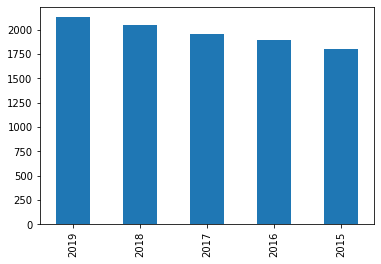

In [ ]:
bb['fyr'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
year_dummy = pd.get_dummies(bb['fyr'])
year_dummy
year_dummy.columns = ['fyr_15', 'fyr_16', 'fyr_17', 'fyr_18', 'fyr_19']
year_dummy

,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1
...,...,...,...,...,...
13192,0,0,0,0,1
13193,0,0,0,1,0
13194,0,0,0,0,1
13195,0,0,0,1,0


In [ ]:
cc = bb.join(year_dummy)
cc

,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m,A,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19
0,A000040,2015,12.313316,0.349469,3.286386,-0.158294,NaN,-0.158294,6371.0,2646.632,NaN,16719.73480,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1,1,0,0,0,0
1,A000040,2016,11.931636,0.419225,2.602186,-0.166240,NaN,-0.166240,6372.0,1636.234,NaN,9842.59190,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1,0,1,0,0,0
2,A000040,2017,11.021674,0.405069,1.460460,-0.010917,NaN,-0.010917,6373.0,422.363,NaN,38688.16375,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1,0,0,1,0,0
3,A000040,2018,11.074281,0.361883,1.218728,-0.010309,NaN,-0.010309,6374.0,251.856,NaN,24431.11664,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1,0,0,0,1,0
4,A000040,2019,10.875308,0.505333,2.850656,-0.009291,NaN,-0.009291,6375.0,376.220,NaN,40493.80568,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13192,A950140,2019,11.382999,0.161295,1.436661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.1964,2021,3,0.073664,12,0.510124,0.461137,1.599241,-0.021357,0.132054,12,1.295162,0.113890,2,0,0,0,0,0,1
13193,A950160,2018,14.783599,0.084899,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,0.0000,2020,3,-0.124661,12,0.021357,-0.076507,-0.525944,-0.096244,0.201565,12,0.824842,0.172563,2,0,0,0,0,1,0
13194,A950160,2019,13.101246,0.137109,5.311746,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.0000,2021,3,0.073664,12,NaN,NaN,0.000000,0.000000,0.000000,12,-0.525944,0.201565,2,0,0,0,0,0,1
13195,A950170,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,-0.2908,2020,3,-0.124661,12,0.629952,0.592947,2.176122,-0.007121,0.153560,12,1.199482,0.151335,2,0,0,0,0,1,0


In [ ]:
ind = pd.read_excel(r'/content/drive/MyDrive/주석txt/산업분류.xlsx')
ind

,symbol,fyr,i_dummy
0,A005930,2015,제조업
1,A005930,2016,제조업
2,A005930,2017,제조업
3,A005930,2018,제조업
4,A005930,2019,제조업
...,...,...,...
13435,A158310,2016,제조업
13436,A158310,2017,제조업
13437,A158310,2018,제조업
13438,A158310,2019,제조업


In [ ]:
dd = pd.merge(cc,ind, on = ('symbol','fyr'), how= 'left')
dd

,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m,A,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,i_dummy
0,A000040,2015,12.313316,0.349469,3.286386,-0.158294,NaN,-0.158294,6371.0,2646.632,NaN,16719.73480,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1,1,0,0,0,0,제조업
1,A000040,2016,11.931636,0.419225,2.602186,-0.166240,NaN,-0.166240,6372.0,1636.234,NaN,9842.59190,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1,0,1,0,0,0,제조업
2,A000040,2017,11.021674,0.405069,1.460460,-0.010917,NaN,-0.010917,6373.0,422.363,NaN,38688.16375,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1,0,0,1,0,0,제조업
3,A000040,2018,11.074281,0.361883,1.218728,-0.010309,NaN,-0.010309,6374.0,251.856,NaN,24431.11664,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1,0,0,0,1,0,제조업
4,A000040,2019,10.875308,0.505333,2.850656,-0.009291,NaN,-0.009291,6375.0,376.220,NaN,40493.80568,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1,0,0,0,0,1,제조업
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,A950140,2019,11.382999,0.161295,1.436661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.1964,2021,3,0.073664,12,0.510124,0.461137,1.599241,-0.021357,0.132054,12,1.295162,0.113890,2,0,0,0,0,0,1,제조업
9826,A950160,2018,14.783599,0.084899,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,0.0000,2020,3,-0.124661,12,0.021357,-0.076507,-0.525944,-0.096244,0.201565,12,0.824842,0.172563,2,0,0,0,0,1,0,제조업
9827,A950160,2019,13.101246,0.137109,5.311746,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.0000,2021,3,0.073664,12,NaN,NaN,0.000000,0.000000,0.000000,12,-0.525944,0.201565,2,0,0,0,0,0,1,제조업
9828,A950170,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,-0.2908,2020,3,-0.124661,12,0.629952,0.592947,2.176122,-0.007121,0.153560,12,1.199482,0.151335,2,0,0,0,0,1,0,NaN


In [ ]:
ind_dummy = pd.get_dummies(dd['i_dummy'])
ind_dummy
ind_dummy.columns = ['ind_1','ind_2','ind_3','ind_4','ind_5','ind_6','ind_7','ind_8','ind_9','ind_10','ind_11','ind_12','ind_13','ind_14','ind_15','ind_16','ind_17']
ind_dummy

,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9826,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9827,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9828,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
market = pd.read_excel(r'/content/drive/MyDrive/주석txt/거래소.xlsx')
market_dummy = pd.get_dummies(market['market'])
del market_dummy['K-OTC']
del market_dummy['KONEX']
market_dummy = market_dummy.rename({'유가증권시장':'KOSPI','코스닥':'KOSDAQ'},axis='columns')
market_dummy = market.join(market_dummy)
market_dummy
del market_dummy['market']
market_dummy

market_dummy['MARKET'] = np.where(pd.notnull(market_dummy['KOSPI']) == True, market_dummy['KOSPI'], market_dummy['KOSDAQ'])
market_dummy

,symbol,fyr,KOSPI,KOSDAQ,MARKET
0,A005930,2015,1,0,1
1,A005930,2016,1,0,1
2,A005930,2017,1,0,1
3,A005930,2018,1,0,1
4,A005930,2019,1,0,1
...,...,...,...,...,...
11240,A008800,2015,0,1,0
11241,A008800,2016,0,1,0
11242,A008800,2017,0,1,0
11243,A008800,2018,0,1,0


In [ ]:
data

,Unnamed: 0,Unnamed: 0.1,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m,A,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,i_dummy,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
0,0,0,A000040,2015,12.313316,0.349469,3.286386,0.158294,NaN,0.158294,6371.0,2646.632,NaN,16719.73480,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,A000040,2016,11.931636,0.419225,2.602186,0.166240,NaN,0.166240,6372.0,1636.234,NaN,9842.59190,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,2,A000040,2017,11.021674,0.405069,1.460460,0.010917,NaN,0.010917,6373.0,422.363,NaN,38688.16375,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,3,A000040,2018,11.074281,0.361883,1.218728,0.010309,NaN,0.010309,6374.0,251.856,NaN,24431.11664,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,4,4,A000040,2019,10.875308,0.505333,2.850656,0.009291,NaN,0.009291,6375.0,376.220,NaN,40493.80568,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9670,9670,9670,A950140,2019,11.382999,0.161295,1.436661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.1964,2021,3,0.073664,12,0.510124,0.461137,1.599241,-0.021357,0.132054,12,1.295162,0.113890,2,0,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9671,9671,9671,A950160,2018,14.783599,0.084899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,0.0000,2020,3,-0.124661,12,0.021357,-0.076507,-0.525944,-0.096244,0.201565,12,0.824842,0.172563,2,0,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9672,9672,9672,A950160,2019,13.101246,0.137109,5.311746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.0000,2021,3,0.073664,12,NaN,NaN,0.000000,0.000000,0.000000,12,-0.525944,0.201565,2,0,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9673,9673,9673,A950170,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,-0.2908,2020,3,-0.124661,12,0.629952,0.592947,2.176122,-0.007121,0.153560,12,1.199482,0.151335,2,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = pd.merge(data,market_dummy, on = ('symbol','fyr'), how= 'left')
data
data.to_excel(r'/content/drive/MyDrive/주석txt/최종.xlsx')

In [ ]:
# cc = pd.merge(bb,ind, on = ('symbol','fyr'), how= 'left')
# dd = pd.merge(cc,year_dummy, how='left')
ee = dd.join(ind_dummy)
ee

In [ ]:
ee

,symbol,fyr,size,lev,mtb,fxrisk,fxrisk_i,fxrisk_m,A,effect,effect_i,ni_before_tax,ni_before_tax_i,단위백만원,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,industry,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
0,A000040,2015,12.313316,0.349469,3.286386,-0.158294,NaN,-0.158294,6371.0,2646.632,NaN,16719.73480,16144.54800,NaN,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,A000040,2016,11.931636,0.419225,2.602186,-0.166240,NaN,-0.166240,6372.0,1636.234,NaN,9842.59190,11056.37895,NaN,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,A000040,2017,11.021674,0.405069,1.460460,-0.010917,NaN,-0.010917,6373.0,422.363,NaN,38688.16375,28903.47882,NaN,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,A000040,2018,11.074281,0.361883,1.218728,-0.010309,NaN,-0.010309,6374.0,251.856,NaN,24431.11664,16372.45416,NaN,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,A000040,2019,10.875308,0.505333,2.850656,-0.009291,NaN,-0.009291,6375.0,376.220,NaN,40493.80568,54037.97107,NaN,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,A950140,2019,11.382999,0.161295,1.436661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.1964,2021,3,0.073664,12,0.510124,0.461137,1.599241,-0.021357,0.132054,12,1.295162,0.113890,2,0,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9826,A950160,2018,14.783599,0.084899,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,0.0000,2020,3,-0.124661,12,0.021357,-0.076507,-0.525944,-0.096244,0.201565,12,0.824842,0.172563,2,0,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9827,A950160,2019,13.101246,0.137109,5.311746,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-03-31,0.0000,2021,3,0.073664,12,NaN,NaN,0.000000,0.000000,0.000000,12,-0.525944,0.201565,2,0,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9828,A950170,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2020-03-31,-0.2908,2020,3,-0.124661,12,0.629952,0.592947,2.176122,-0.007121,0.153560,12,1.199482,0.151335,2,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ee.to_excel(r'/content/drive/MyDrive/주석txt/최종.xlsx')



In [ ]:
data = pd.merge(ee,market_dummy, on = ('symbol','fyr'), how= 'left')
data
data.to_excel(r'/content/drive/MyDrive/주석txt/최종.xlsx')

In [ ]:

ee.rename(columns = {'i_dummy' : 'industry'}, inplace = True)
ee


In [ ]:
#회귀분석시작

In [ ]:
# data=pd.read_excel(r'/content/drive/MyDrive/주석txt/최종F.xlsx')
data=pd.read_excel(r'/content/drive/MyDrive/주석txt/최종데이터 (2).xlsx')
data
# data['fxrisk_m'] = data['fxrisk_m'].abs()
# data

,Unnamed: 0,symbol,fyr,size,sizedum,lev,mtb,fxrisk_m,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,industry,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17,KOSPI,KOSDAQ,MARKET
0,580,A005930,2019,19.623995,1.0,0.049823,1.306762,0.021797,1,2021-03-31,-0.0133,2021,3,0.073664,12,0.110571,0.021628,0.465399,0.021208,0.082543,12,1.138565,0.074039,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0
1,578,A005930,2017,19.611395,1.0,0.061426,1.587460,0.011949,1,2019-03-31,-0.0100,2019,3,0.001013,12,0.497232,0.446956,0.723849,-0.003848,0.079190,12,-0.355240,0.058897,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0
2,577,A005930,2016,19.350891,1.0,0.053589,1.359823,0.019466,1,2018-03-31,0.0459,2018,3,0.022098,12,0.078683,-0.013449,-0.355241,0.021108,0.058897,12,-0.208152,0.048757,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0
3,579,A005930,2018,19.258061,1.0,0.043122,0.962351,0.013711,1,2020-03-31,-0.1190,2020,3,-0.124661,12,0.741810,0.715991,1.138565,0.029663,0.074039,12,0.723849,0.079190,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0
4,576,A005930,2015,19.039089,1.0,0.052244,1.073581,0.011384,1,2017-03-31,0.0718,2017,3,0.014637,12,0.026689,-0.070642,-0.208152,0.040369,0.048757,12,1.347597,0.089794,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9503,6219,A033250,2015,NaN,NaN,NaN,NaN,NaN,12,2017-03-31,-0.1168,2017,3,0.014637,12,0.143470,0.057816,1.461878,-0.058048,0.147691,12,-1.838873,0.306134,2,0,1,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
9504,5974,A026260,2016,NaN,NaN,NaN,NaN,NaN,12,2018-03-31,-0.2313,2018,3,0.022098,12,0.054958,-0.039547,0.487634,-0.123916,0.096736,12,-1.928299,0.223748,2,0,0,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
9505,8207,A095300,2015,NaN,NaN,NaN,NaN,NaN,12,2017-03-31,-0.4552,2017,3,0.014637,12,0.103728,0.014101,-1.529421,-0.071774,0.181719,12,-2.260885,0.321593,2,0,1,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
9506,9126,A189330,2019,NaN,NaN,0.274624,NaN,NaN,12,2021-03-31,0.2395,2021,3,0.073664,12,0.059137,-0.034950,1.065668,0.048008,0.258446,12,-3.365543,0.396214,2,0,0,0,0,0,1,"출판, 영상, 방송통신 및 정보서비스업",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0


In [ ]:
fff = pd.read_excel(r'/content/drive/MyDrive/주석txt/감사인외국인.xlsx')
fff['foreign'] = fff['foreign']/100
fff

,symbol,fyr,audit,foreign
0,A005930,2015,1,0.524760
1,A005930,2016,1,0.536081
2,A005930,2017,1,0.558164
3,A005930,2018,1,0.593025
4,A005930,2019,1,0.603376
...,...,...,...,...
11245,A158310,2015,1,0.018159
11246,A158310,2016,0,0.009082
11247,A158310,2017,0,0.010994
11248,A158310,2018,0,0.018864


In [ ]:
data = pd.merge(data, fff, on = ('symbol','fyr'), how= 'left')
data

,Unnamed: 0,symbol,fyr,size,sizedum,lev,mtb,fxrisk_m,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,industry,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17,KOSPI,KOSDAQ,MARKET,audit,foreign
0,580,A005930,2019,19.623995,1.0,0.049823,1.306762,0.021797,1,2021-03-31,-0.0133,2021,3,0.073664,12,0.110571,0.021628,0.465399,0.021208,0.082543,12,1.138565,0.074039,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.603376
1,578,A005930,2017,19.611395,1.0,0.061426,1.587460,0.011949,1,2019-03-31,-0.0100,2019,3,0.001013,12,0.497232,0.446956,0.723849,-0.003848,0.079190,12,-0.355240,0.058897,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.558164
2,577,A005930,2016,19.350891,1.0,0.053589,1.359823,0.019466,1,2018-03-31,0.0459,2018,3,0.022098,12,0.078683,-0.013449,-0.355241,0.021108,0.058897,12,-0.208152,0.048757,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.536081
3,579,A005930,2018,19.258061,1.0,0.043122,0.962351,0.013711,1,2020-03-31,-0.1190,2020,3,-0.124661,12,0.741810,0.715991,1.138565,0.029663,0.074039,12,0.723849,0.079190,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.593025
4,576,A005930,2015,19.039089,1.0,0.052244,1.073581,0.011384,1,2017-03-31,0.0718,2017,3,0.014637,12,0.026689,-0.070642,-0.208152,0.040369,0.048757,12,1.347597,0.089794,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.524760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9503,6219,A033250,2015,NaN,NaN,NaN,NaN,NaN,12,2017-03-31,-0.1168,2017,3,0.014637,12,0.143470,0.057816,1.461878,-0.058048,0.147691,12,-1.838873,0.306134,2,0,1,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
9504,5974,A026260,2016,NaN,NaN,NaN,NaN,NaN,12,2018-03-31,-0.2313,2018,3,0.022098,12,0.054958,-0.039547,0.487634,-0.123916,0.096736,12,-1.928299,0.223748,2,0,0,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
9505,8207,A095300,2015,NaN,NaN,NaN,NaN,NaN,12,2017-03-31,-0.4552,2017,3,0.014637,12,0.103728,0.014101,-1.529421,-0.071774,0.181719,12,-2.260885,0.321593,2,0,1,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
9506,9126,A189330,2019,NaN,NaN,0.274624,NaN,NaN,12,2021-03-31,0.2395,2021,3,0.073664,12,0.059137,-0.034950,1.065668,0.048008,0.258446,12,-3.365543,0.396214,2,0,0,0,0,0,1,"출판, 영상, 방송통신 및 정보서비스업",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
data['fxaudit'] = data['fxrisk_m']*data['audit']
data['fxforeign'] = data['fxrisk_m']*data['foreign']
data['fxsize'] = data['fxrisk_m']*data['sizedum']
data

,Unnamed: 0,symbol,fyr,size,sizedum,lev,mtb,fxrisk_m,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,industry,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17,KOSPI,KOSDAQ,MARKET,audit,foreign,fxaudit,fxforeign,fxsize
0,580,A005930,2019,19.623995,1.0,0.049823,1.306762,0.021797,1,2021-03-31,-0.0133,2021,3,0.073664,12,0.110571,0.021628,0.465399,0.021208,0.082543,12,1.138565,0.074039,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.603376,0.021797,0.013152,0.021797
1,578,A005930,2017,19.611395,1.0,0.061426,1.587460,0.011949,1,2019-03-31,-0.0100,2019,3,0.001013,12,0.497232,0.446956,0.723849,-0.003848,0.079190,12,-0.355240,0.058897,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.558164,0.011949,0.006669,0.011949
2,577,A005930,2016,19.350891,1.0,0.053589,1.359823,0.019466,1,2018-03-31,0.0459,2018,3,0.022098,12,0.078683,-0.013449,-0.355241,0.021108,0.058897,12,-0.208152,0.048757,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.536081,0.019466,0.010435,0.019466
3,579,A005930,2018,19.258061,1.0,0.043122,0.962351,0.013711,1,2020-03-31,-0.1190,2020,3,-0.124661,12,0.741810,0.715991,1.138565,0.029663,0.074039,12,0.723849,0.079190,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.593025,0.013711,0.008131,0.013711
4,576,A005930,2015,19.039089,1.0,0.052244,1.073581,0.011384,1,2017-03-31,0.0718,2017,3,0.014637,12,0.026689,-0.070642,-0.208152,0.040369,0.048757,12,1.347597,0.089794,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.524760,0.011384,0.005974,0.011384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9503,6219,A033250,2015,NaN,NaN,NaN,NaN,NaN,12,2017-03-31,-0.1168,2017,3,0.014637,12,0.143470,0.057816,1.461878,-0.058048,0.147691,12,-1.838873,0.306134,2,0,1,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9504,5974,A026260,2016,NaN,NaN,NaN,NaN,NaN,12,2018-03-31,-0.2313,2018,3,0.022098,12,0.054958,-0.039547,0.487634,-0.123916,0.096736,12,-1.928299,0.223748,2,0,0,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9505,8207,A095300,2015,NaN,NaN,NaN,NaN,NaN,12,2017-03-31,-0.4552,2017,3,0.014637,12,0.103728,0.014101,-1.529421,-0.071774,0.181719,12,-2.260885,0.321593,2,0,1,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9506,9126,A189330,2019,NaN,NaN,0.274624,NaN,NaN,12,2021-03-31,0.2395,2021,3,0.073664,12,0.059137,-0.034950,1.065668,0.048008,0.258446,12,-3.365543,0.396214,2,0,0,0,0,0,1,"출판, 영상, 방송통신 및 정보서비스업",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN


In [ ]:
data.to_excel(r'/content/drive/MyDrive/주석txt/교차항통합.xlsx')

In [ ]:
# data = data.dropna()
# data

,Unnamed: 0,symbol,fyr,size,lev,mtb,fxrisk_m,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,industry,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17,KOSPI,KOSDAQ,MARKET,audit,foreign
0,0,A000040,2015,12.313316,0.349469,3.286386,0.158294,1,2017-03-31,-0.0027,2017,3,0.014637,12,0.487873,0.436661,0.998454,-0.033920,0.054701,12,-0.211416,0.103132,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,11.262975
1,1,A000040,2016,11.931636,0.419225,2.602186,0.166240,1,2018-03-31,0.0285,2018,3,0.022098,12,0.485475,0.434022,2.527486,-0.078232,0.168699,12,0.998454,0.054701,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,11.608553
2,2,A000040,2017,11.021674,0.405069,1.460460,0.010917,1,2019-03-31,-0.0272,2019,3,0.001013,12,0.182210,0.100431,0.450812,-0.009002,0.081473,12,2.527486,0.168699,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,11.417645
3,3,A000040,2018,11.074281,0.361883,1.218728,0.010309,1,2020-03-31,-0.0582,2020,3,-0.124661,12,0.097248,0.006973,0.784603,-0.069657,0.140915,12,0.450812,0.081473,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,23.797119
4,4,A000040,2019,10.875308,0.505333,2.850656,0.009291,1,2021-03-31,0.0648,2021,3,0.073664,12,0.145605,0.060165,1.425495,0.004767,0.220320,12,0.784603,0.140915,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,16.446883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9818,9818,A950130,2015,12.182850,0.003524,3.063298,0.283758,12,2017-03-31,-0.0993,2017,3,0.014637,12,0.338612,0.272473,1.281474,-0.040577,0.084271,12,-1.501145,0.144327,2,0,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,1.0,10.752831
9819,9819,A950130,2016,12.017554,0.264160,2.882739,10.841980,12,2018-03-31,-0.0307,2018,3,0.022098,12,0.663773,0.630150,2.030068,-0.017439,0.115880,12,1.281474,0.084271,2,0,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,1.0,6.455683
9820,9820,A950130,2017,11.727690,0.250243,2.813266,0.040262,12,2019-03-31,0.0251,2019,3,0.001013,12,0.465061,0.411568,0.688209,-0.013182,0.077852,12,2.030068,0.115880,2,0,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,6.370758
9821,9821,A950130,2018,11.661113,0.286159,3.103583,0.017263,12,2020-03-31,0.9308,2020,3,-0.124661,12,0.223080,0.145388,-2.590695,0.004978,0.307209,12,0.688209,0.077852,2,0,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,6.990420


In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from patsy import dmatrices, PatsyError
import scipy.stats as stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
des = data[['fxrisk_m','beta','lag_beta','SDRET','lag_SDRET','size','lev','mtb','MARKET','audit','foreign','fxaudit','fxforeign','sizedum','fxsize']]
dess=des.describe(percentiles=[.01,.25,.75,.99])
df = des.median()
df = df.to_frame(name='median')
df = df.transpose()
df = pd.concat([dess,df])
df = df.reindex(index=['count','mean','min','1%','25%','median','75%','99%','max','std'])
df = df.transpose()
df

,count,mean,min,1%,25%,median,75%,99%,max,std
fxrisk_m,6019.0,0.393267,0.000000,0.000000,0.014476,0.064954,0.220100,5.703204,77.028071,2.243079
beta,9508.0,0.971672,-3.990134,-1.288283,0.472177,0.953410,1.442185,3.304113,3.998914,0.841754
lag_beta,9508.0,0.979450,-4.066969,-1.539954,0.434192,0.951092,1.471912,3.792062,4.965108,0.942088
SDRET,9508.0,0.131812,0.000000,0.000000,0.082199,0.113917,0.160823,0.428693,0.898693,0.080138
lag_SDRET,9508.0,0.129321,0.000000,0.019068,0.080530,0.111423,0.155818,0.430016,1.098245,0.079574
size,9113.0,12.030046,9.222269,9.882523,11.087390,11.726237,12.663232,16.641784,19.623995,1.379562
lev,8830.0,0.193345,0.000000,0.000000,0.043998,0.175663,0.303595,0.633846,0.885930,0.161256
mtb,8536.0,2.022829,0.120152,0.286514,0.756769,1.249055,2.233803,13.295953,80.566546,2.935768
MARKET,9119.0,0.393245,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.488497
audit,9097.0,0.471034,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.499188


In [ ]:
#말도 안되는 수치만 지우자
# idx = data[data.fxrisk_m<8] #fxrisk 는 안건들이는게 맞는건가? 많이 차이가 안나니까?
# idx = data[data.size>9.2]
idx = data[data['size']<9.22].index
data.drop(idx,inplace=True)
idx = data[data.beta>-5]
idx = idx[idx.beta<5]
idx = idx[idx.lag_beta>-5]
idx = idx[idx.lag_beta<5]
# idx = idx[idx.SDRET>0]
# # # idx = data[data.SDRET<0.84] #0.1퍼
# idx = idx[idx.lag_SDRET>0]
# idx = data[data.lag_SDRET<0.91]
# idx = idx[idx.size>9.22]
# # idx = data[data.size<16.527132]
# # idx = data[data.lev] lev최소값 0 은 어떻게해야하지?
# idx = data[data.lev<0.88]
idx = idx[idx.mtb>0]
idx = idx[idx.mtb<80]
idx = idx[idx.SDRET>0]
# # idx = data[data.SDRET<0.84] #0.1퍼
idx = idx[idx.lag_SDRET>0]
idx = idx[idx.ind_4==0]
idx

,Unnamed: 0,symbol,fyr,size,sizedum,lev,mtb,fxrisk_m,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,industry,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17,KOSPI,KOSDAQ,MARKET,audit,foreign,fxaudit,fxforeign,fxsize
0,580,A005930,2019,19.623995,1.0,0.049823,1.306762,0.021797,1,2021-03-31,-0.0133,2021,3,0.073664,12,0.110571,0.021628,0.465399,0.021208,0.082543,12,1.138565,0.074039,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.603376,0.021797,0.013152,0.021797
1,578,A005930,2017,19.611395,1.0,0.061426,1.587460,0.011949,1,2019-03-31,-0.0100,2019,3,0.001013,12,0.497232,0.446956,0.723849,-0.003848,0.079190,12,-0.355240,0.058897,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.558164,0.011949,0.006669,0.011949
2,577,A005930,2016,19.350891,1.0,0.053589,1.359823,0.019466,1,2018-03-31,0.0459,2018,3,0.022098,12,0.078683,-0.013449,-0.355241,0.021108,0.058897,12,-0.208152,0.048757,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.536081,0.019466,0.010435,0.019466
3,579,A005930,2018,19.258061,1.0,0.043122,0.962351,0.013711,1,2020-03-31,-0.1190,2020,3,-0.124661,12,0.741810,0.715991,1.138565,0.029663,0.074039,12,0.723849,0.079190,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.593025,0.013711,0.008131,0.013711
4,576,A005930,2015,19.039089,1.0,0.052244,1.073581,0.011384,1,2017-03-31,0.0718,2017,3,0.014637,12,0.026689,-0.070642,-0.208152,0.040369,0.048757,12,1.347597,0.089794,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.524760,0.011384,0.005974,0.011384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9108,9297,A208350,2015,9.263312,0.0,0.000000,1.317075,NaN,12,2017-03-31,0.0759,2017,3,0.014637,12,0.002691,-0.097040,0.142955,-0.016452,0.105462,12,0.584191,0.050224,2,0,1,0,0,0,0,"출판, 영상, 방송통신 및 정보서비스업",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,1.0,0.0,0.0,0.000000,NaN,NaN,NaN
9109,9508,A226360,2016,9.253783,0.0,0.000000,0.517705,NaN,12,2018-03-31,-0.0356,2018,3,0.022098,12,0.477824,0.425606,1.376480,-0.028053,0.092607,12,0.125314,0.013541,2,0,0,1,0,0,0,건설업,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.000383,NaN,NaN,NaN
9110,9608,A250930,2017,9.246479,0.0,0.526484,1.100550,NaN,12,2019-03-31,0.0197,2019,3,0.001013,12,0.001321,-0.098547,0.005287,0.002720,0.011223,12,0.046062,0.011138,2,0,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.000000,NaN,NaN,NaN
9111,9493,A225590,2016,9.228573,0.0,0.151672,0.741691,NaN,12,2018-03-31,-0.0273,2018,3,0.022098,12,0.537031,0.490734,0.811225,-0.013080,0.051481,12,0.099397,0.016118,2,0,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.002062,NaN,NaN,NaN


In [ ]:
des_m = idx[['fxrisk_m','beta','lag_beta','SDRET','lag_SDRET','size','lev','mtb','MARKET','audit' , 'foreign','fxaudit','fxforeign','sizedum','fxsize']]
dess_m=des_m.describe(percentiles=[.01,.25,.75,.99])
df_m = des_m.median()
df_m = df_m.to_frame(name='median')
df_m = df_m.transpose()
df_m = pd.concat([dess_m,df_m])
df_m
df_m = df_m.reindex(index=['count','mean','min','1%','25%','median','75%','99%','max','std'])
df_m = df_m.transpose()
df_m

,count,mean,min,1%,25%,median,75%,99%,max,std
fxrisk_m,5774.0,0.404314,0.000000,0.000000,0.014784,0.066895,0.223923,5.998862,77.028071,2.288843
beta,8398.0,0.997478,-3.871903,-1.164211,0.499653,0.974830,1.462155,3.332664,3.998914,0.833856
lag_beta,8398.0,0.982352,-4.066969,-1.567567,0.444466,0.956838,1.476841,3.792564,4.965108,0.942957
SDRET,8398.0,0.134154,0.004977,0.030979,0.084600,0.116234,0.162215,0.407058,0.898693,0.078254
lag_SDRET,8398.0,0.129305,0.004891,0.029651,0.081753,0.112113,0.155107,0.407080,1.098245,0.076282
size,8398.0,12.013564,9.222269,9.907833,11.094425,11.726427,12.627203,16.579240,19.623995,1.346869
lev,8398.0,0.193738,0.000000,0.000000,0.045735,0.177415,0.303882,0.617164,0.885930,0.159762
mtb,8398.0,1.985442,0.126386,0.290436,0.754686,1.241106,2.207849,12.930465,64.584934,2.724487
MARKET,8398.0,0.385211,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.486674
audit,8378.0,0.466340,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.498896


In [ ]:
#윈서라이징

In [ ]:
# idx['fxrisk_m'] = np.where(idx['fxrisk_m']<0.000001, 0.000001,idx['fxrisk_m'])
# idx['fxrisk_m'] = np.where(idx['fxrisk_m']>1.514577,1.514577 ,idx['fxrisk_m'])
idx['fxrisk_m'] = np.where(idx['fxrisk_m']>5.998862,5.998862 ,idx['fxrisk_m'])
idx['beta'] = np.where(idx['beta']<-1.164211, -1.164211,idx['beta'])
idx['beta'] = np.where(idx['beta']>3.332664, 3.332664,idx['beta'])
idx['lag_beta'] = np.where(idx['lag_beta']<-1.567567, -1.567567,idx['lag_beta'])
idx['lag_beta'] = np.where(idx['lag_beta']>3.792564, 3.792564	,idx['lag_beta'])
idx['SDRET'] = np.where(idx['SDRET']<0.030979, 0.030979,idx['SDRET'])
idx['SDRET'] = np.where(idx['SDRET']>0.407058, 0.407058,idx['SDRET'])
idx['lag_SDRET'] = np.where(idx['lag_SDRET']<0.029651, 0.029651,idx['lag_SDRET'])
idx['lag_SDRET'] = np.where(idx['lag_SDRET']>0.407080, 0.407080,idx['lag_SDRET'])
idx['size'] = np.where(idx['size']<9.907833	, 9.907833	,idx['size'])
# idx['size'] = np.where(idx['size']>16.446825, 16.446825,idx['size']) # 사이즈 큰기업들 윈설라이징 해주는게 맞는건가. 해주면 p값은 낮아짐
idx['mtb'] = np.where(idx['mtb']<0.290436, 0.290436,idx['mtb'])
idx['mtb'] = np.where(idx['mtb']>12.930465, 12.930465,idx['mtb'])

idx['fxaudit'] = np.where(idx['fxaudit']>2.545885, 2.545885,idx['fxaudit'])

idx['fxforeign'] = np.where(idx['fxforeign']>0.295818, 0.295818,idx['fxforeign'])

idx['fxsize'] = np.where(idx['fxsize']>1.346264, 1.346264,idx['fxsize'])

In [ ]:
des_m = idx[['fxrisk_m','beta','lag_beta','SDRET','lag_SDRET','size','lev','mtb','MARKET','audit','foreign','fxaudit','fxforeign','sizedum','fxsize']]
dess_m=des_m.describe(percentiles=[.01,.05,.25,.75,.99])
df_m = des_m.median()
df_m = df_m.to_frame(name='median')
df_m = df_m.transpose()
df_m = pd.concat([dess_m,df_m])
df_m
df_m = df_m.reindex(index=['count','mean','min','1%','25%','median','75%','99%','max','std'])
df_m = df_m.transpose()
df_m

,count,mean,min,1%,25%,median,75%,99%,max,std
fxrisk_m,5774.0,0.301144,0.000000,0.000000,0.014784,0.066895,0.223923,5.989315,5.998862,0.789302
beta,8398.0,1.001754,-1.164211,-1.163563,0.499653,0.974830,1.462155,3.332637,3.332664,0.800867
lag_beta,8398.0,0.986127,-1.567567,-1.567399,0.444466,0.956838,1.476841,3.792541,3.792564,0.901067
SDRET,8398.0,0.132850,0.030979,0.030982,0.084600,0.116234,0.162215,0.407041,0.407058,0.070679
lag_SDRET,8398.0,0.128097,0.029651,0.029652,0.081753,0.112113,0.155107,0.407071,0.407080,0.068693
size,8398.0,12.016436,9.907833,9.907925,11.094425,11.726427,12.627203,16.579240,19.623995,1.341866
lev,8398.0,0.193738,0.000000,0.000000,0.045735,0.177415,0.303882,0.617164,0.885930,0.159762
mtb,8398.0,1.907202,0.290436,0.290455,0.754686,1.241106,2.207849,12.928503,12.930465,2.025058
MARKET,8398.0,0.385211,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.486674
audit,8378.0,0.466340,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.498896


In [ ]:
df_m.to_excel(r'/content/drive/MyDrive/주석txt/기술통계.xlsx')

In [ ]:
#기술통계분석
re_p = des_m.corr(method='pearson')
re_p

,fxrisk_m,beta,lag_beta,SDRET,lag_SDRET,size,lev,mtb,MARKET
fxrisk_m,1.000000,0.072342,0.060835,0.039458,0.006043,-0.117359,0.115722,-0.082872,-0.018813
beta,0.072342,1.000000,0.110777,0.340434,0.130373,-0.142656,0.045324,-0.004618,-0.100935
lag_beta,0.060835,0.110777,1.000000,0.093710,0.328857,-0.140367,0.047193,0.035643,-0.106711
SDRET,0.039458,0.340434,0.093710,1.000000,0.297374,-0.225780,0.126473,0.147913,-0.194376
lag_SDRET,0.006043,0.130373,0.328857,0.297374,1.000000,-0.129703,0.117431,0.336850,-0.209530
size,-0.117359,-0.142656,-0.140367,-0.225780,-0.129703,1.000000,-0.068267,0.206636,0.400950
lev,0.115722,0.045324,0.047193,0.126473,0.117431,-0.068267,1.000000,0.042911,0.065305
mtb,-0.082872,-0.004618,0.035643,0.147913,0.336850,0.206636,0.042911,1.000000,-0.202025
MARKET,-0.018813,-0.100935,-0.106711,-0.194376,-0.209530,0.400950,0.065305,-0.202025,1.000000


In [ ]:
re_p.to_excel(r'/content/drive/MyDrive/주석txt/피어슨1.xlsx')

In [ ]:
re_s = des_m.corr(method='spearman')
re_s

,fxrisk_m,beta,lag_beta,SDRET,lag_SDRET,size,lev,mtb,MARKET
fxrisk_m,1.000000,0.096619,0.086809,0.050093,0.019160,-0.124385,0.113668,-0.127692,-0.054640
beta,0.096619,1.000000,0.153192,0.433698,0.185868,-0.133890,0.067332,0.023006,-0.113452
lag_beta,0.086809,0.153192,1.000000,0.165946,0.411691,-0.140642,0.074331,0.044870,-0.119519
SDRET,0.050093,0.433698,0.165946,1.000000,0.380957,-0.233158,0.148399,0.209145,-0.234026
lag_SDRET,0.019160,0.185868,0.411691,0.380957,1.000000,-0.126648,0.139055,0.395045,-0.247854
size,-0.124385,-0.133890,-0.140642,-0.233158,-0.126648,1.000000,-0.077813,0.193872,0.371586
lev,0.113668,0.067332,0.074331,0.148399,0.139055,-0.077813,1.000000,-0.009090,0.077452
mtb,-0.127692,0.023006,0.044870,0.209145,0.395045,0.193872,-0.009090,1.000000,-0.303385
MARKET,-0.054640,-0.113452,-0.119519,-0.234026,-0.247854,0.371586,0.077452,-0.303385,1.000000


In [ ]:
re_s.to_excel(r'/content/drive/MyDrive/주석txt/스피어만1.xlsx')

In [ ]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

def calculate_pvalues_p(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
p_p = calculate_pvalues_p(des_m)
p_p

,fxrisk_m,beta,lag_beta,SDRET,lag_SDRET,size,lev,mtb,MARKET
fxrisk_m,0,0,0,0.0025,0.6436,0,0,0,0.1496
beta,0,0,0,0,0,0,0.0016,0.2644,0
lag_beta,0,0,0,0,0,0,0.0027,0.0435,0
SDRET,0.0025,0,0,0,0,0,0,0,0
lag_SDRET,0.6436,0,0,0,0,0,0,0,0
size,0,0,0,0,0,0,0,0,0
lev,0,0.0016,0.0027,0,0,0,0,0.6743,0
mtb,0,0.2644,0.0435,0,0,0,0.6743,0,0
MARKET,0.1496,0,0,0,0,0,0,0,0


In [ ]:
p_p.to_excel(r'/content/drive/MyDrive/주석txt/피어슨2.xlsx')

In [ ]:
def calculate_pvalues_s(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
    return pvalues
p_s = calculate_pvalues_s(des_m)
p_s    

,fxrisk_m,beta,lag_beta,SDRET,lag_SDRET,size,lev,mtb,MARKET
fxrisk_m,0,0,0,0.0001,0.1423,0,0,0,0
beta,0,0,0,0,0,0,0,0.8309,0
lag_beta,0,0,0,0,0,0,0,0.1146,0
SDRET,0.0001,0,0,0,0,0,0,0,0
lag_SDRET,0.1423,0,0,0,0,0,0,0,0
size,0,0,0,0,0,0,0,0,0
lev,0,0,0,0,0,0,0,0.0019,0
mtb,0,0.8309,0.1146,0,0,0,0.0019,0,0
MARKET,0,0,0,0,0,0,0,0,0


In [ ]:
p_s.to_excel(r'/content/drive/MyDrive/주석txt/스피어만2.xlsx')

In [ ]:
#idx로 회귀분석 beta
model = smf.ols(formula = 'beta ~ fxrisk_m + lag_beta + size + lev + mtb + audit + foreign + fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx)
result = model.fit()
result.summary()
# result.resid

In [ ]:
idx1 = idx.dropna(subset=['fxrisk_m'], how='all')
idx1

,Unnamed: 0,symbol,fyr,size,sizedum,lev,mtb,fxrisk_m,count,date,monthlyRet,cyear,month,meanRET,_Nobs,_R2,_adjR2,beta,_b_cons,SDRET,max,lag_beta,lag_SDRET,_merge,RISKdisclosure,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,industry,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17,KOSPI,KOSDAQ,MARKET,audit,foreign,fxaudit,fxforeign,fxsize
0,580,A005930,2019,19.623995,1.0,0.049823,1.306762,0.021797,1,2021-03-31,-0.0133,2021,3,0.073664,12,0.110571,0.021628,0.465399,0.021208,0.082543,12,1.138565,0.074039,3,1,0,0,0,0,1,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.603376,0.021797,0.013152,0.021797
1,578,A005930,2017,19.611395,1.0,0.061426,1.587460,0.011949,1,2019-03-31,-0.0100,2019,3,0.001013,12,0.497232,0.446956,0.723849,-0.003848,0.079190,12,-0.355240,0.058897,3,1,0,0,1,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.558164,0.011949,0.006669,0.011949
2,577,A005930,2016,19.350891,1.0,0.053589,1.359823,0.019466,1,2018-03-31,0.0459,2018,3,0.022098,12,0.078683,-0.013449,-0.355241,0.021108,0.058897,12,-0.208152,0.048757,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.536081,0.019466,0.010435,0.019466
3,579,A005930,2018,19.258061,1.0,0.043122,0.962351,0.013711,1,2020-03-31,-0.1190,2020,3,-0.124661,12,0.741810,0.715991,1.138565,0.029663,0.074039,12,0.723849,0.079190,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.593025,0.013711,0.008131,0.013711
4,576,A005930,2015,19.039089,1.0,0.052244,1.073581,0.011384,1,2017-03-31,0.0718,2017,3,0.014637,12,0.026689,-0.070642,-0.208152,0.040369,0.048757,12,1.347597,0.089794,3,1,1,0,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0.524760,0.011384,0.005974,0.011384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9071,3880,A222080,2016,9.907833,0.0,0.041246,0.424400,0.095944,1,2018-03-31,0.0396,2018,3,0.022098,12,0.006814,-0.092504,-0.150994,0.023983,0.085065,12,-0.364318,0.051310,3,1,0,1,0,0,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.000350,0.000000,0.000034,0.000000
9079,3639,A182690,2018,9.907833,0.0,0.615349,2.538661,0.018499,1,2020-03-31,0.4661,2020,3,-0.124661,12,0.000480,-0.099472,0.149810,0.154271,0.383086,12,0.816378,0.159740,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.025602,0.000000,0.000474,0.000000
9087,2037,A053060,2018,9.907833,0.0,0.348746,0.557660,0.066131,1,2020-03-31,-0.3043,2020,3,-0.124661,12,0.596461,0.556108,1.531312,0.004209,0.111050,12,1.880879,0.159858,3,1,0,0,0,1,0,제조업,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,1.0,0.003631,0.066131,0.000240,0.000000
9089,9058,A173130,2017,9.907833,0.0,0.048414,0.722180,0.138157,12,2019-03-31,0.0000,2019,3,0.001013,12,0.300586,0.230644,1.621255,0.055897,0.228124,12,0.042586,0.189013,2,0,0,0,1,0,0,"출판, 영상, 방송통신 및 정보서비스업",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
idx2 = idx1[['symbol','fyr','beta','fxrisk_m','lag_beta' ,'SDRET','lag_SDRET', 'size' ,'lev' ,'mtb' ,'MARKET','audit','foreign', 'fxaudit','fxforeign','sizedum','fxsize', 'fyr_15'  , 'fyr_16' , 'fyr_17' , 'fyr_18' , 'fyr_19' , 'ind_1' ,'ind_2' ,'ind_3','ind_5','ind_6','ind_7','ind_8','ind_9','ind_10','ind_11','ind_12','ind_13','ind_14','ind_15','ind_16','ind_17']]
idx2

,symbol,fyr,beta,fxrisk_m,lag_beta,SDRET,lag_SDRET,size,lev,mtb,MARKET,audit,foreign,fxaudit,fxforeign,sizedum,fxsize,fyr_15,fyr_16,fyr_17,fyr_18,fyr_19,ind_1,ind_2,ind_3,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
0,A005930,2019,0.465399,0.021797,1.138565,0.082543,0.074039,19.623995,0.049823,1.306762,1.0,1.0,0.603376,0.021797,0.013152,1.0,0.021797,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,A005930,2017,0.723849,0.011949,-0.355240,0.079190,0.058897,19.611395,0.061426,1.587460,1.0,1.0,0.558164,0.011949,0.006669,1.0,0.011949,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,A005930,2016,-0.355241,0.019466,-0.208152,0.058897,0.048757,19.350891,0.053589,1.359823,1.0,1.0,0.536081,0.019466,0.010435,1.0,0.019466,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,A005930,2018,1.138565,0.013711,0.723849,0.074039,0.079190,19.258061,0.043122,0.962351,1.0,1.0,0.593025,0.013711,0.008131,1.0,0.013711,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,A005930,2015,-0.208152,0.011384,1.347597,0.048757,0.089794,19.039089,0.052244,1.073581,1.0,1.0,0.524760,0.011384,0.005974,1.0,0.011384,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9071,A222080,2016,-0.150994,0.095944,-0.364318,0.085065,0.051310,9.907833,0.041246,0.424400,0.0,0.0,0.000350,0.000000,0.000034,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9079,A182690,2018,0.149810,0.018499,0.816378,0.383086,0.159740,9.907833,0.615349,2.538661,0.0,0.0,0.025602,0.000000,0.000474,0.0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9087,A053060,2018,1.531312,0.066131,1.880879,0.111050,0.159858,9.907833,0.348746,0.557660,0.0,1.0,0.003631,0.066131,0.000240,0.0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9089,A173130,2017,1.621255,0.138157,0.042586,0.228124,0.189013,9.907833,0.048414,0.722180,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
idx1.isnull().sum()

In [ ]:
dt = idx2.set_index(['symbol','fyr'])
dt

beta  fxrisk_m  lag_beta  ...  ind_15  ind_16  ind_17
symbol  fyr                                 ...                        
A000040 2015  0.998454  0.158294 -0.211416  ...       0       0       0
        2016  2.527486  0.166240  0.998454  ...       0       0       0
        2017  0.450812  0.010917  2.527486  ...       0       0       0
        2018  0.784603  0.010309  0.450812  ...       0       0       0
        2019  1.425495  0.009291  0.784603  ...       0       0       0
...                ...       ...       ...  ...     ...     ...     ...
A298020 2019  0.306150  0.301045  0.971600  ...       0       0       0
A298040 2019  0.526756  0.096101  1.209810  ...       0       0       0
A298050 2019  0.291416  0.686531  1.344348  ...       0       0       0
A299900 2019  1.063376  0.087143  1.294092  ...       1       0       0
A302430 2019  2.583112  0.265852  1.518166  ...       0       0       0

[3838 rows x 28 columns]

In [ ]:

dt = idx2.set_index(['symbol','fyr'])
mod = PanelOLS(dt['beta'], dt[['fxrisk_m','lag_beta' , 'size' ,'lev' ,'mtb' , 'fyr_15' , 'fyr_16' , 'fyr_17' , 'fyr_18' , 'fyr_19' , 'ind_1' ,'ind_2' ,'ind_3','ind_5','ind_6','ind_7','ind_8','ind_9','ind_10','ind_11','ind_12','ind_13','ind_14','ind_15','ind_16','ind_17']],entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered' ,cluster_entity=True,cluster_time=True)
res

In [ ]:
model = smf.ols(formula = 'beta ~ fxrisk_m +  fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx2)
result = model.fit(cov_type='cluster', cov_kwds={'groups':idx2['symbol']},use_t=True)
result.summary()

In [ ]:
model = smf.ols(formula = 'beta ~ fxrisk_m + lag_beta + size + lev + mtb + MARKET + fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx2)
result = model.fit(cov_type='cluster', cov_kwds={'groups':idx2['symbol']},use_t=True)
result.summary()


# reg_model = smf.ols("enroll ~ treatment + C(year) + C(institution)", df)
# .fit(cov_type='cluster', cov_kwds={'groups': df['institution']})

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 27, but rank is 25
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beta   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     153.2
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:47:39   Log-Likelihood:                -6700.0
No. Observations:                5774   AIC:                         1.345e+04
Df Residuals:                    5747   BIC:                         1.363e+04
Df Model:                          26                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4398      0.090     15.990      0.000       1.263       1.616
fxrisk_m       0.0447      0.014      3.239      0.001       0.018       0.072
lag_beta       0.0830      0.014      6.116      0.000       0.056       0.110
size          -0.0690      0.008     -8.203      0.000      -0.085      -0.052
lev            0.1352      0.074      1.831      0.067      -0.010       0.280
mtb            0.0033      0.006      0.530      0.596      -0.009       0.015
MARKET        -0.0318      0.027     -1.171      0.242      -0.085       0.021
fyr_15         0.2466      0.031      8.015      0.000       0.186       0.307
fyr_16         0.1763      0.028      6.279      0.000       0.121       0.231
fyr_17         0.3096      0.024     13.100      0.000       0.263       0.356
fyr_18         0.4012      0.028     14.518      0.000       0.347       0.455
fyr_19         0.3061      0.028     11.012      0.000       0.252       0.361
ind_1          0.1533      0.075      2.035      0.042       0.006       0.301
ind_2         -0.1390      0.147     -0.945      0.345      -0.427       0.149
ind_3         -0.4946      0.235     -2.102      0.036      -0.956      -0.033
ind_5         -0.0681      0.092     -0.736      0.462      -0.249       0.113
ind_6         -0.0255      0.058     -0.439      0.661      -0.139       0.088
ind_7         -0.4500      0.037    -12.239      0.000      -0.522      -0.378
ind_8         -0.1783      0.160     -1.113      0.266      -0.493       0.136
ind_9          0.0085      0.147      0.057      0.954      -0.280       0.297
ind_10         0.0161      0.154      0.105      0.917      -0.285       0.317
ind_11        -0.0342      0.087     -0.392      0.695      -0.205       0.137
ind_12        -0.2641      0.137     -1.925      0.054      -0.533       0.005
ind_13        -0.0470      0.057     -0.830      0.406      -0.158       0.064
ind_14        -0.0063      0.041     -0.154      0.877      -0.087       0.074
ind_15        -0.0021      0.052     -0.041      0.967      -0.104       0.100
ind_16        -0.3290      0.108     -3.059      0.002      -0.540      -0.118
ind_17        -0.1736      0.047     -3.693      0.000      -0.266      -0.081
==============================================================================
Omnibus:                      132.277   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.125
Skew:                           0.111   Prob(JB):                     1.81e-60
Kurtosis:                       4.046   Cond. No.                     5.01e+15
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 3.67e-26. This might indicate that there are
strong mu

In [ ]:
model = smf.ols(formula = 'beta ~  fxrisk_m + lag_beta + size + lev + mtb + MARKET + foreign + audit + fxaudit + fxforeign + sizedum + fxsize +fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx2)
result = model.fit(cov_type='cluster', cov_kwds={'groups':idx2['symbol']},use_t=True)
result.summary()


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 31
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beta   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     124.6
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:38:23   Log-Likelihood:                -6686.5
No. Observations:                5774   AIC:                         1.344e+04
Df Residuals:                    5741   BIC:                         1.366e+04
Df Model:                          32                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0929      0.122      8.927      0.000       0.853       1.333
fxrisk_m       0.0365      0.021      1.777      0.076      -0.004       0.077
lag_beta       0.0794      0.014      5.858      0.000       0.053       0.106
size          -0.0287      0.013     -2.178      0.030      -0.055      -0.003
lev            0.0845      0.075      1.126      0.260      -0.063       0.232
mtb            0.0029      0.006      0.461      0.645      -0.009       0.015
MARKET        -0.0351      0.027     -1.286      0.199      -0.089       0.018
foreign       -0.4710      0.121     -3.903      0.000      -0.708      -0.234
audit          0.0381      0.028      1.384      0.167      -0.016       0.092
fxaudit        0.0074      0.042      0.178      0.859      -0.074       0.089
fxforeign     -0.0619      0.380     -0.163      0.871      -0.807       0.684
sizedum       -0.1000      0.037     -2.713      0.007      -0.172      -0.028
fxsize         0.0844      0.073      1.148      0.251      -0.060       0.228
fyr_15         0.1730      0.035      4.918      0.000       0.104       0.242
fyr_16         0.1030      0.033      3.168      0.002       0.039       0.167
fyr_17         0.2391      0.029      8.160      0.000       0.182       0.297
fyr_18         0.3364      0.032     10.511      0.000       0.274       0.399
fyr_19         0.2414      0.032      7.505      0.000       0.178       0.304
ind_1          0.1371      0.081      1.699      0.090      -0.021       0.295
ind_2         -0.1017      0.112     -0.908      0.364      -0.321       0.118
ind_3         -0.5321      0.239     -2.229      0.026      -1.000      -0.064
ind_5         -0.1028      0.110     -0.936      0.349      -0.318       0.113
ind_6         -0.0355      0.067     -0.531      0.595      -0.166       0.096
ind_7         -0.4711      0.048     -9.880      0.000      -0.565      -0.378
ind_8         -0.1464      0.154     -0.949      0.343      -0.449       0.156
ind_9          0.0703      0.164      0.430      0.667      -0.251       0.391
ind_10        -0.0056      0.149     -0.038      0.970      -0.298       0.287
ind_11        -0.0577      0.096     -0.599      0.549      -0.247       0.131
ind_12        -0.3011      0.138     -2.187      0.029      -0.571      -0.031
ind_13        -0.0690      0.066     -1.053      0.293      -0.198       0.060
ind_14        -0.0103      0.053     -0.195      0.845      -0.114       0.093
ind_15        -0.0150      0.061     -0.245      0.807      -0.136       0.106
ind_16        -0.3399      0.117     -2.916      0.004      -0.569      -0.111
ind_17        -0.0389      0.072     -0.540      0.589      -0.180       0.102
==============================================================================
Omnibus:                      129.506   Durbin-Watson:                   2.000
Pr

In [ ]:
model = smf.ols(formula = 'fxrisk_m~ foreign + audit + size + lev + mtb + MARKET +  fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx2)
result = model.fit(cov_type='cluster', cov_kwds={'groups':idx2['symbol']},use_t=True)
result.summary()

In [ ]:
# import statsmodels.api as sm
# data = sm.datasets.stackloss.load(as_pandas=False)
# data.exog = sm.add_constant(data.exog)
# rlm_model = sm.RLM(data.endog, data.exog,                            M=sm.robust.norms.Hube

In [ ]:
#idx로 회귀분석 SDRET
model = smf.ols(formula = 'SDRET ~ fxrisk_m + size + lev + mtb + fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx)
result = model.fit()
result.summary()

In [ ]:
model = smf.ols(formula = 'SDRET ~ fxrisk_m + fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx1)
result = model.fit(cov_type='cluster', cov_kwds={'groups': idx1['symbol']},use_t=True)
result.summary()

In [ ]:
model = smf.ols(formula = 'SDRET ~ fxrisk_m  + size + lev + mtb + MARKET +audit + foreign +fxaudit+ fxforeign + sizedum + fxsize + fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx2)
result = model.fit(cov_type='cluster', cov_kwds={'groups': idx1['symbol']},use_t=True)
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 30
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SDRET   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     148.7
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:40:31   Log-Likelihood:                 7897.1
No. Observations:                5774   AIC:                        -1.573e+04
Df Residuals:                    5742   BIC:                        -1.552e+04
Df Model:                          31                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1732      0.012     14.893      0.000       0.150       0.196
fxrisk_m       0.0022      0.002      1.312      0.190      -0.001       0.005
size          -0.0076      0.001     -6.089      0.000      -0.010      -0.005
lev            0.0388      0.007      5.638      0.000       0.025       0.052
mtb            0.0064      0.001     10.208      0.000       0.005       0.008
MARKET        -0.0086      0.003     -3.311      0.001      -0.014      -0.003
audit         -0.0039      0.003     -1.554      0.120      -0.009       0.001
foreign       -0.0376      0.011     -3.558      0.000      -0.058      -0.017
fxaudit       -0.0037      0.004     -1.041      0.298      -0.011       0.003
fxforeign     -0.0371      0.031     -1.185      0.236      -0.098       0.024
sizedum       -0.0055      0.003     -1.795      0.073      -0.012       0.001
fxsize         0.0163      0.006      2.752      0.006       0.005       0.028
fyr_15         0.0131      0.003      4.737      0.000       0.008       0.019
fyr_16         0.0165      0.003      6.149      0.000       0.011       0.022
fyr_17         0.0422      0.003     15.149      0.000       0.037       0.048
fyr_18         0.0367      0.003     13.555      0.000       0.031       0.042
fyr_19         0.0647      0.003     21.841      0.000       0.059       0.070
ind_1          0.0147      0.009      1.603      0.109      -0.003       0.033
ind_2          0.0725      0.024      2.995      0.003       0.025       0.120
ind_3         -0.0499      0.017     -2.904      0.004      -0.084      -0.016
ind_5         -0.0308      0.007     -4.230      0.000      -0.045      -0.017
ind_6          0.0075      0.006      1.223      0.222      -0.005       0.020
ind_7         -0.0388      0.005     -8.155      0.000      -0.048      -0.029
ind_8         -0.0192      0.015     -1.305      0.192      -0.048       0.010
ind_9          0.0118      0.022      0.526      0.599      -0.032       0.056
ind_10        -0.0001      0.008     -0.016      0.987      -0.016       0.015
ind_11         0.0091      0.010      0.881      0.379      -0.011       0.029
ind_12        -0.0237      0.009     -2.725      0.007      -0.041      -0.007
ind_13         0.0031      0.006      0.490      0.624      -0.009       0.016
ind_14         0.0049      0.005      0.930      0.353      -0.005       0.015
ind_15         0.0071      0.006      1.164      0.244      -0.005       0.019
ind_16         0.0050      0.019      0.260      0.795      -0.032       0.042
ind_17        -0.0292      0.007     -4.180      0.000      -0.043      -0.016
==============================================================================
Omnibus:                     1576.930   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4472.556
Sk

In [ ]:
#idx로 회귀분석 SDRET(통제변수제외)
model = smf.ols(formula = 'SDRET ~ fxrisk_m + lag_SDRET + fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = idx)
result = model.fit()
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SDRET   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     39.25
Date:                Sat, 29 May 2021   Prob (F-statistic):          8.87e-145
Time:                        06:45:42   Log-Likelihood:                 5219.6
No. Observations:                3838   AIC:                        -1.040e+04
Df Residuals:                    3816   BIC:                        -1.026e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0941      0.030      3.136      0.002       0.035       0.153
fxrisk_m       0.0071      0.003      2.059      0.040       0.000       0.014
lag_SDRET      0.3231      0.016     20.400      0.000       0.292       0.354
fyr_15        -0.0038      0.006     -0.591      0.555      -0.016       0.009
fyr_16         0.0051      0.006      0.814      0.416      -0.007       0.018
fyr_17         0.0292      0.006      4.610      0.000       0.017       0.042
fyr_18         0.0160      0.006      2.542      0.011       0.004       0.028
fyr_19         0.0474      0.006      7.489      0.000       0.035       0.060
ind_1         -0.0226      0.037     -0.615      0.539      -0.094       0.049
ind_2          0.0292      0.057      0.512      0.608      -0.083       0.141
ind_3         -0.0454      0.041     -1.107      0.268      -0.126       0.035
ind_5         -0.0588      0.039     -1.518      0.129      -0.135       0.017
ind_6         -0.0246      0.036     -0.681      0.496      -0.096       0.046
ind_7         -0.0581      0.048     -1.221      0.222      -0.151       0.035
ind_8         -0.0361      0.039     -0.925      0.355      -0.113       0.040
ind_9         -0.0106      0.041     -0.258      0.797      -0.091       0.070
ind_10        -0.0254      0.042     -0.603      0.546      -0.108       0.057
ind_11        -0.0246      0.037     -0.669      0.504      -0.097       0.048
ind_12        -0.0579      0.038     -1.510      0.131      -0.133       0.017
ind_13        -0.0403      0.036     -1.113      0.266      -0.111       0.031
ind_14        -0.0246      0.036     -0.684      0.494      -0.095       0.046
ind_15        -0.0235      0.036     -0.651      0.515      -0.094       0.047
ind_16         0.0033      0.041      0.082      0.935      -0.076       0.083
ind_17              0          0        nan        nan           0           0
==============================================================================
Omnibus:                     1315.868   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4700.971
Skew:                           1.705   Prob(JB):                         0.00
Kurtosis:                       7.216   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#data로 회귀분석 beta(윈서라이징 안한것)
model = smf.ols(formula = 'beta ~ fxrisk_m + lag_beta + size + lev + mtb + audit + foreign +  fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = data)
result = model.fit()
result.summary()


In [ ]:
#data로 회귀분석 SDRET
model = smf.ols(formula = 'SDRET ~ fxrisk_m + lag_SDRET + size + lev + mtb + fyr_15  + fyr_16 + fyr_17 + fyr_18 + fyr_19 + ind_1 +ind_2 +ind_3+ind_4+ind_5+ind_6+ind_7+ind_8+ind_9+ind_10+ind_11+ind_12+ind_13+ind_14+ind_15+ind_16+ind_17', data = data)
result = model.fit()
result.summary()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
model.exog_names

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')